<p style="text-align: center;">
  <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/2/2c/Universit%C3%A9_Panth%C3%A9on-Sorbonne_%28depuis_janvier_2015%29.svg/1200px-Universit%C3%A9_Panth%C3%A9on-Sorbonne_%28depuis_janvier_2015%29.svg.png?20161020031138" alt="Description de l'image" style="width: 30%;"/>
</p>

# <h2 style="color:#0c3c6c; font-weight:bold; text-align: center;">PROJET BIG DATA ANALYTICS</h2>
# <h3 style="color:#0c3c6c; text-align: center;">Thomas Barbosa Medeiros - Élodie Hutin - Clément Ribeiro Da Silva</h3>

# <span style="color:#bc851f; font-weight:bold;">EXERCICE I</span>

On souhaite afficher pour les utilisateurs d’un réseau social le nombre d’amis en commun avec un autre utilisateur quand il visite la page de ce dernier.
1. Écrivez sous python, un programme de type MapReduce qui calcule le nombre d’amis en communs pour chaque paire d’utilisateurs sachant que le fichier amis.txt contient les identifiants des utilisateurs suivis des identifiants de leurs amis.
2. Ré-ecrirez votre programme MapReduce en utilisant Pyspark.

NB : Un programme de type MapReduce comprend deux phases : une phase de map où vous auriez en sortie des données sous forme clé-valeur, et une phase d’aggrégation. Vous pouvez vous inspirer des indications en fin de chapitre 2.

# <span style="color:#943838;">Chargement des bibliothèques nécessaires</span>

In [1]:
import numpy as np
from functools import reduce
from tabulate import tabulate
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# <span style="color:#943838;">Programme Python</span>

In [2]:
# Fonction pour mapper les données
def emit_friend_pairs(line):
    user_id, friends = line.strip().split(':')
    friends = friends.split(',')
    return (user_id, friends)

# Fonction pour réduire et compter les amis en commun
def count_common_friends(total_common_friends, pair):
    user1, friends1 = pair
    for user2, friends2 in friend_data:
        if user1 != user2:
            common_friends = set(friends1) & set(friends2)
            total_count = len(common_friends)
            total_common_friends[(user1,user2)] = total_count
    return total_common_friends

# Charger le fichier amis.txt
with open("ex1_amis.txt", "r") as file:
    file.readline()
    # Mapper les données pour obtenir les amis de chaque utilisateur
    friend_data = list(map(emit_friend_pairs, file))
    
    # Réduire pour compter les amis en commun entre tous les utilisateurs
    total_common_friends = reduce(count_common_friends, friend_data, {})
    
# Afficher les résultats sous forme de tableau
all_users = sorted(set(user for user, _ in friend_data))
table_data = np.zeros((len(all_users), len(all_users)), dtype=int)

# Remplir le tableau avec les nombres d'amis en commun
for i, user1 in enumerate(all_users):
    for j, user2 in enumerate(all_users):
        if user1 != user2:
            table_data[i, j] = total_common_friends.get((user1, user2), 0)

print(tabulate(table_data, headers=all_users, showindex=all_users, tablefmt="grid"))

+----+------+------+------+------+------+
|    |   10 |   20 |   30 |   40 |   50 |
+====+======+======+======+======+======+
| 10 |    0 |    2 |    2 |    2 |    2 |
+----+------+------+------+------+------+
| 20 |    2 |    0 |    2 |    2 |    2 |
+----+------+------+------+------+------+
| 30 |    2 |    2 |    0 |    3 |    1 |
+----+------+------+------+------+------+
| 40 |    2 |    2 |    3 |    0 |    1 |
+----+------+------+------+------+------+
| 50 |    2 |    2 |    1 |    1 |    0 |
+----+------+------+------+------+------+


# <span style="color:#943838;">Programme Spark</span>

In [3]:
# Configuration de Spark
conf = SparkConf().setAppName("FriendCommonCount").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

# Fonction pour réduire et compter les amis en commun
def count_common_friends(pair):
    user1, friends1 = pair
    common_friends = []
    for user2, friends2 in friend_data_broadcast.value:
        if user1 != user2 and user1 != "Id_utilisateur " and user2 != "Id_utilisateur ":
            common_friends.append(((user1, user2), len(set(friends1) & set(friends2))))
    return common_friends

# Charger le fichier amis.txt et mapper les données
friend_data_rdd = sc.textFile("ex1_amis.txt").map(emit_friend_pairs)
friend_data_broadcast = sc.broadcast(friend_data_rdd.collect())

# Réduire pour compter les amis en commun entre tous les utilisateurs
common_friends_rdd = friend_data_rdd.flatMap(count_common_friends)
total_common_friends = common_friends_rdd.reduceByKey(lambda x, y: x + y).collect()


all_users = sorted(set(user for user, _ in friend_data_broadcast.value) - {"Id_utilisateur "})
table_data = np.zeros((len(all_users), len(all_users)), dtype=int)

for (user1, user2), count in total_common_friends:
    i = all_users.index(user1)
    j = all_users.index(user2)
    table_data[i, j] = count

print(tabulate(table_data, headers=all_users, showindex=all_users, tablefmt="grid"))

# Arrêter Spark
sc.stop()

+----+------+------+------+------+------+
|    |   10 |   20 |   30 |   40 |   50 |
+====+======+======+======+======+======+
| 10 |    0 |    2 |    2 |    2 |    2 |
+----+------+------+------+------+------+
| 20 |    2 |    0 |    2 |    2 |    2 |
+----+------+------+------+------+------+
| 30 |    2 |    2 |    0 |    3 |    1 |
+----+------+------+------+------+------+
| 40 |    2 |    2 |    3 |    0 |    1 |
+----+------+------+------+------+------+
| 50 |    2 |    2 |    1 |    1 |    0 |
+----+------+------+------+------+------+


# <span style="color:#bc851f; font-weight:bold;">EXERCICE II</span>

Écrire un programme qui prend en entrée un fichier contenant une liste de liens (url) de pages web et un nombre entier k, puis, collecte des informations/données et renvoie les k mots les plus fréquents sur chaque page web.
Pour illustrer, vous supposerez que les données recherchées sont les adresses email valident de chaque page. Une fois collectées, votre programme stockera ces données ainsi que les k mots les plus fréquents sur chaque page web, dans un fichier se trouvant sur le disque dur.
Lorsque cela est possible, l’utilisation du MapReduce sur Spark ou une procédure du type MapReduce sur Python est vivement recommandée.

# <span style="color:#943838;">Chargement des bibliothèques nécessaires</span>

In [4]:
from pyspark import SparkContext
from bs4 import BeautifulSoup
import random
import re
import requests
from collections import Counter

# <span style="color:#943838;">Définition d'un SparkContext et du nombre entier k</span>

In [82]:
sc = SparkContext()
k = random.randint(2, 20)
k

3

# <span style="color:#943838;">Programme Spark de scrapping</span>

In [83]:
def recherche(url):
    # Récupére contenu d'une page web à partir de l'URL fournie en format txt
    content = requests.get(url).text 
    # Crée un objet Soup avec contenu de la page. ['html.parser' spécifie le parseur à utiliser pour décomposer le contenu HTML]
    soup = BeautifulSoup(content, 'html.parser') 
    # Extrait le texte du document HTML, sans les balises HTML pour n'avoir que le contenu textuel pur
    text = soup.get_text()
    # Recherche tous les 'mots' 
    words = re.findall(r'[a-zA-Z]+', text.lower())    
    # Compte chaque mot de 'words' avec Counter
    counter = Counter(words) 
    # Renvoie tuple du mot le plus commun avec son nombre d'occurences
    frequent_words = counter.most_common(k)
    # Recherche adresse mail 
    emails = re.findall(r"[A-Za-z0-9\._\-+]+@[A-Za-z0-9\._\-+]+\.[a-zA-Z]{2,6}", content) 
    return (url, {'emails': emails, 'frequent_words': frequent_words})

# Lecture du fichier txt et création d'un RDD à partir de celui-ci
urls_rdd = sc.textFile("ex2_liens.txt") 
# Mapping des données
results_rdd = urls_rdd.map(recherche)
# Réduction 
results = results_rdd.collect() 
sc.stop()

# <span style="color:#943838;">Importation du résultat sur le disque dur</span>

In [84]:
# Importe le résultat dans un fichier txt sur le disque dur
def save_results(results, output_path):
    with open(output_path, 'w') as file: # crée un fichier txt à l'emplacement choisi
        for result in results:
            url, data = result
            file.write(f"URL: {url}\n")
            file.write("Emails:\n")
            file.write(", ".join(data['emails']) + "\n")
            file.write("Frequent Words:\n")
            for word, count in data['frequent_words']:
                file.write(f"{word}: {count}\n")
            file.write("\n")
save_results(results, "ex2_results.txt")

# <span style="color:#bc851f; font-weight:bold;">EXERCICE III</span>

Le département du crédit à la consommation d’une banque souhaite automatiser le processus de prise de décision pour l’approbation des lignes de crédit hypothécaires. Pour ce faire, ils suivront les recommandations de l’Equal Credit Opportunity Act afin de créer un modèle de score de crédit empiriquement dérivé et statistiquement solide. Ce modèle sera basé sur les données collectées auprès des candidats récents ayant obtenu un crédit par le biais du processus actuel d’octroi de prêts. L’objectif est de construire un modèle suffisamment interprétable pour fournir une justification en cas de décisions défavorables (rejets).

Le jeu de données Home Equity (HMEQ) contient des informations de base et de performance des prêts pour 5 960 prêts hypothécaires récents. La variable cible (BAD) est binaire et indique si un candidat a finalement fait défaut ou a été gravement en retard dans ses paiements. Ce résultat négatif s’est produit dans 1 189 cas (20%). Pour chaque candidat, 12 variables d’entrée ont été enregistrées.
1. Traitez les valeurs manquantes de cette table de données.
2. Proposer à la banque un algorithme de prédiction. Vous pourrez mettre en oeuvre 3 modèles et sélectionner le meilleur sur votre base de test.
Pour cet exercice, l’utilisation de Sagemaker est très recommandé (obligatoire).

# <span style="color:#943838;">Chargement des bibliothèques nécessaires</span>

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso, lars_path, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, log_loss, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from statsmodels.api import Logit
import xgboost as xgb
import kds
from IPython.display import HTML
import base64
from timeit import default_timer as timer
import scipy.stats as ss
import sys
import shap
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

c:\Users\cleme\OneDrive\Bureau\M2_TIDE\17 - Big_Data\PROJET_BARBOSA_HUTIN_RIBEIRO\venv_projet_big_data\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <span style="color:#943838;">Construction du chemin puis chargement des données HMEQ</span>

In [9]:
# Chargement du fichier CSV
df = pd.read_csv(os.path.join(os.getcwd(), 'ex3_dataset_hmeq.csv'), sep=',')

In [10]:
# Affichage des premières lignes
df.head()

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

# <span style="color:#943838;">Nettoyage des données</span>

## <span style="color:#389696;">Gestion des valeurs manquantes</span>

In [11]:
# Quantification du volume concerné
nb_lignes_nan = df.isna().any(axis=1).sum()
print("Nombre de lignes contenant au moins une valeur manquante :", nb_lignes_nan)

Nombre de lignes contenant au moins une valeur manquante : 2596


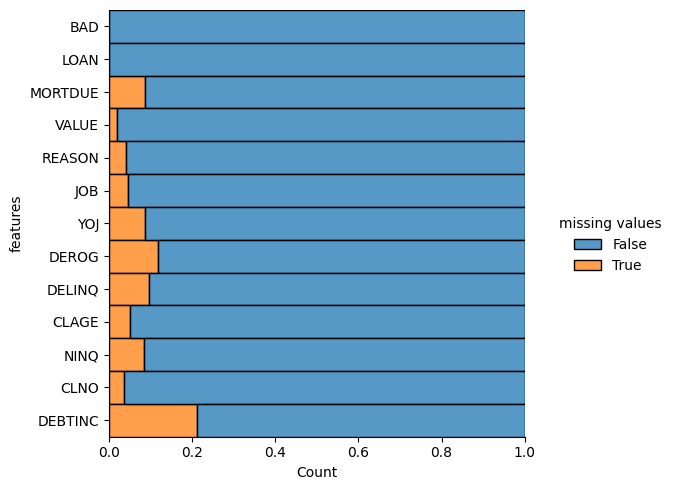

Colonnes avec des valeurs manquantes : ['MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [13]:
# Visualisation des valeurs manquantes
def na_ratio_plot(df):
    missing_values = df.isna().mean()
    missing_columns = missing_values[missing_values > 0].index.tolist()
    
    sns.displot(df.isna().melt(value_name="missing values", var_name='features'),
                y='features', hue="missing values", multiple="fill", aspect=9/8)
    plt.show()
    
    return missing_columns

missing_columns_list = na_ratio_plot(df)
print("Colonnes avec des valeurs manquantes :", missing_columns_list)

Cette cellule crée une fonction pour visualiser le ratio de valeurs manquantes par colonne et affiche les colonnes concernées.

## <span style="color:#389696;">Gestion des valeurs dupliquées</span>

In [14]:
# Analyse des doublons
duplicates_df = df[df.duplicated(keep=False)]
print("Doublons dans les données :", duplicates_df)

Doublons dans les données : Empty DataFrame
Columns: [BAD, LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC]
Index: []


Cette cellule vérifie l'existence de doublons dans le tableau : il y en a aucun.

In [15]:
# Filtrage des lignes avec moins de 5 valeurs manquantes
df = df[df.isna().sum(axis=1) < 5]
print("Dimensions du dataframe après filtrage des lignes avec plus de 4 valeurs manquantes :", df.shape)

Dimensions du dataframe après filtrage des lignes avec plus de 4 valeurs manquantes : (5685, 13)


On filtre les lignes contenant plus de 4 valeurs manquantes (autrement dit 2/3 de l'information), conservant ainsi les lignes avec des informations suffisantes. En effet, on suppose qu'une connaissance minimale du client est nécessaire pour octroyer un prêt bancaire.

In [16]:
df.describe()

BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5685.000000   5685.000000    5300.000000    5596.000000  5333.000000   
mean      0.198945  18861.108179   73980.890543  102763.372773     8.967185   
std       0.399241  11313.246729   44764.401674   57931.155299     7.600831   
min       0.000000   1100.000000    2063.000000    8000.000000     0.000000   
25%       0.000000  11300.000000   46370.500000   66684.500000     3.000000   
50%       0.000000  16500.000000   65000.000000   89844.500000     7.000000   
75%       0.000000  23500.000000   92271.750000  120535.500000    13.000000   
max       1.000000  89900.000000  399550.000000  855909.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  5248.000000  5377.000000  5601.000000  5445.000000  5685.000000   
mean      0.253430     0.449321   179.632347     1.186593    21.373439   
std       0.842566     1.127349    85.539007     1.729207    10.145478   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000   115.558530     0.000000    15.000000   
50%       0.000000     0.000000   173.500000     1.000000    20.000000   
75%       0.000000     0.000000   230.716713     2.000000    26.000000   
max      10.000000    15.000000  1168.233561    17.000000    71.000000   

           DEBTINC  
count  4489.000000  
mean     33.962503  
std       8.597578  
min       0.524499  
25%      29.327514  
50%      34.975655  
75%      39.111039  
max     203.312149

## <span style="color:#389696;">Gestion des valeurs extrêmes</span>

In [17]:
# Analyse des valeurs aberrantes (outliers)
def recherche_outliers(df):
    outliers_found = False
    for col in df.select_dtypes(include=['float']).columns:
        mediane = np.median(df[col])
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        seuil = 3 * iqr
        mask_aberrantes = np.abs(df[col] - mediane) > seuil 
        outliers = df.loc[mask_aberrantes, col]
        if len(outliers) > 0:
            print(f"La colonne '{col}' contient {len(outliers)} outliers")
            outliers_found = True 
    if not outliers_found:
        print("Aucun outlier détecté")

recherche_outliers(df)

La colonne 'CLNO' contient 35 outliers


Ici, on identifie et affiche les valeurs aberrantes pour les colonnes numériques : seule la colonne 'CLNO' (indiquant le nombre de crédits dans la banque) semble concernée.

In [18]:
# Conversion des valeurs de la colonne 'reason' en valeurs numériques
df['REASON'] = df['REASON'].map({'HomeImp': 0, 'DebtCon': 1})

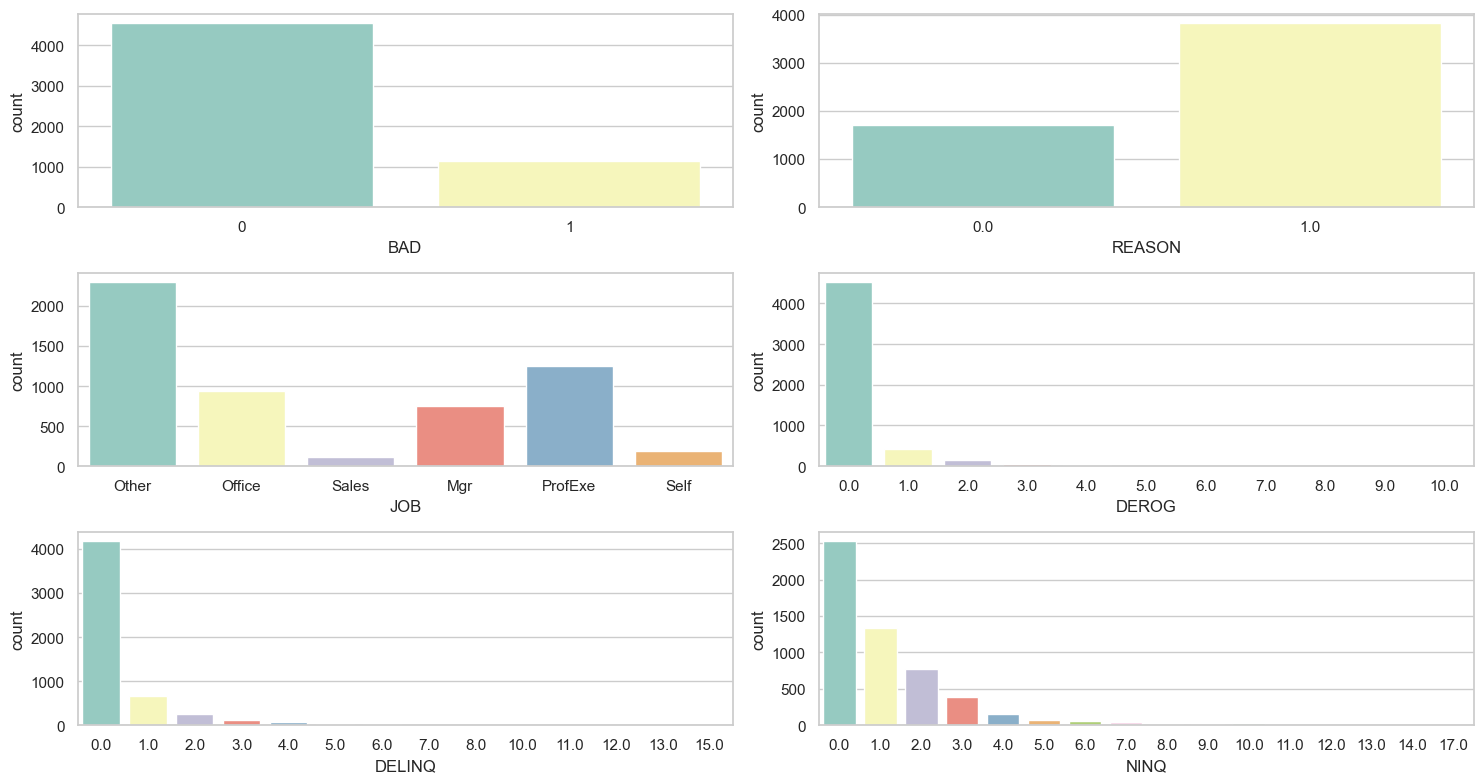

In [19]:
# Visualisation des distributions des variables catégorielles
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")

variables = ['BAD', 'REASON', 'JOB', 'DEROG', 'DELINQ', 'NINQ']
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=var, data=df, palette="Set3")

plt.tight_layout()
plt.show()

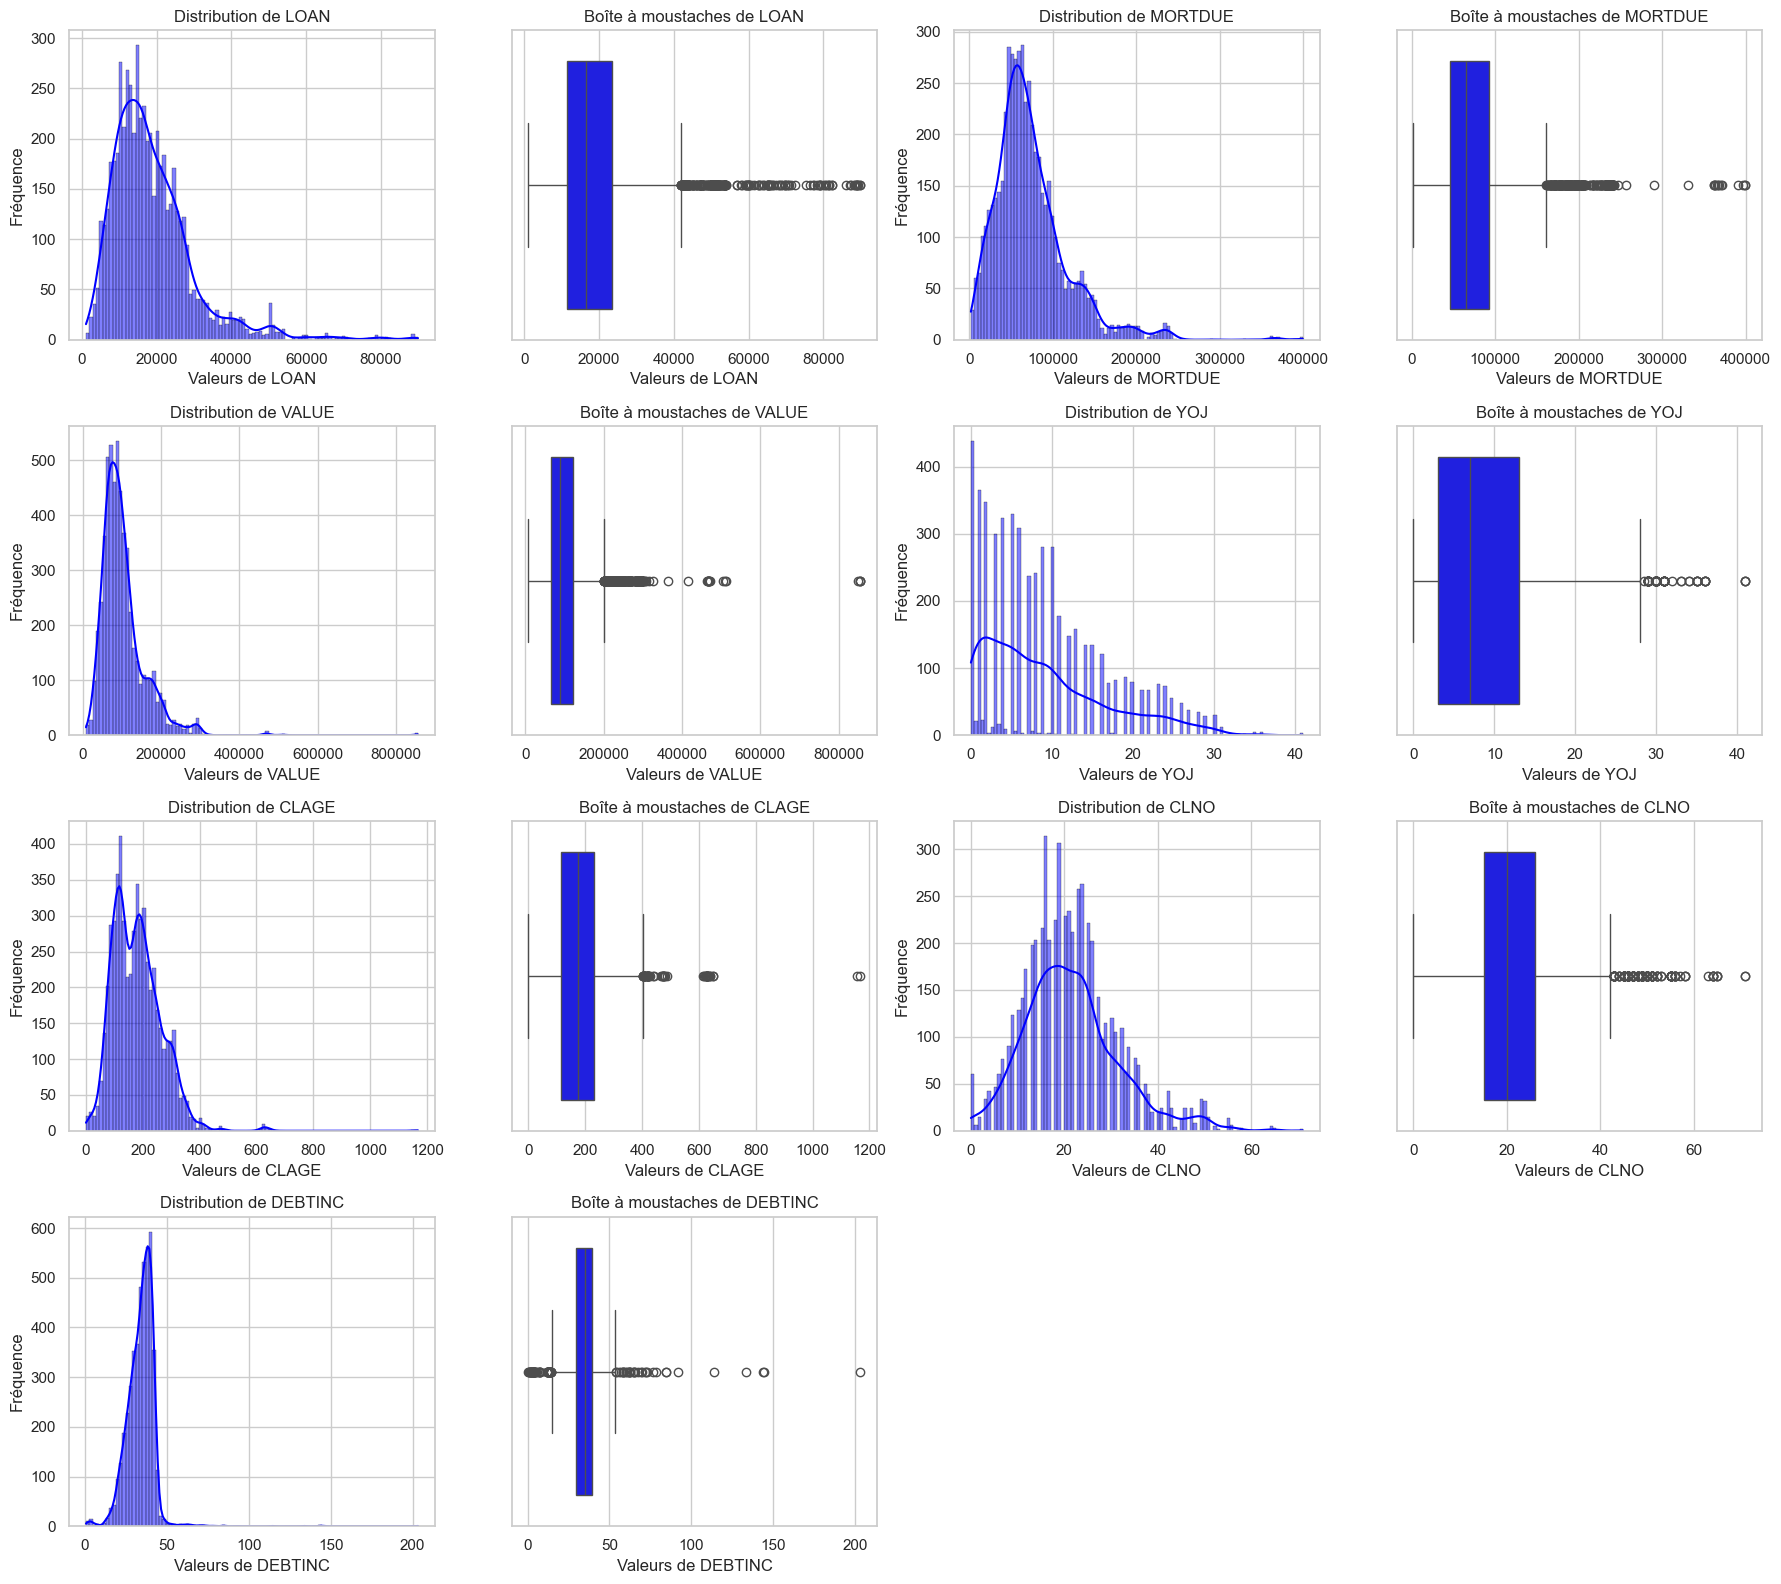

In [20]:
# Visualisation des distributions et des boxplots des variables numériques
liste_var = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC']
num_cols = 2  # Nous avons deux types de graphiques (histogramme et boxplot)
num_rows = (len(liste_var) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols * 2, figsize=(18, 4 * num_rows))

for i, var in enumerate(liste_var):
    row_idx = i // num_cols
    col_idx = i % num_cols * 2

    sns.histplot(df[var], bins=100, kde=True, color='blue', edgecolor='black', ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Distribution de {var}')
    axes[row_idx, col_idx].set_xlabel(f'Valeurs de {var}')
    axes[row_idx, col_idx].set_ylabel('Fréquence')

    sns.boxplot(x=df[var], ax=axes[row_idx, col_idx + 1], color='blue')
    axes[row_idx, col_idx + 1].set_title(f'Boîte à moustaches de {var}')
    axes[row_idx, col_idx + 1].set_xlabel(f'Valeurs de {var}')

# Supprimer les axes inutilisés
for i in range(len(liste_var), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i * 2])
    fig.delaxes(axes.flatten()[i * 2 + 1])

plt.tight_layout()
plt.show()

Pistes de réflexions :

- Nous observons qu'il est très improbable que l'âge du plus ancien crédit (CLAGE) dépasse 1100 mois, soit plus de 90 ans.
- De plus, nous décidons de retirer les propriétés dont la valeur (VALUE) dépasse un demi-million, car cela concerne très peu d'individus (7) qui, de manière surprenante, sont tous en défaut de paiement.
- Cependant, un ratio dette/revenu (DEBTINC) de 200, bien qu'extrême, n'est pas impossible, surtout puisque l'observation correspondante a BAD=1, indiquant que le client a effectivement fait défaut.
- Un maximum de 41 ans d'expérience à l'emploi (YOJ) est également plausible dans le cadre d'une carrière professionnelle complète.

In [21]:
# Gestion des valeurs aberrantes pour 'clage' et 'value'
df = df[df['CLAGE'] < 750]
df = df[df['VALUE'] < 500000]
print("Dimensions du dataframe après filtrage des valeurs aberrantes :", df.shape)

Dimensions du dataframe après filtrage des valeurs aberrantes : (5503, 13)


On vient filtrer les valeurs aberrantes pour les colonnes 'CLAGE' et 'VALUE'.

## <span style="color:#389696;">Stratégie de qualité des données</span>

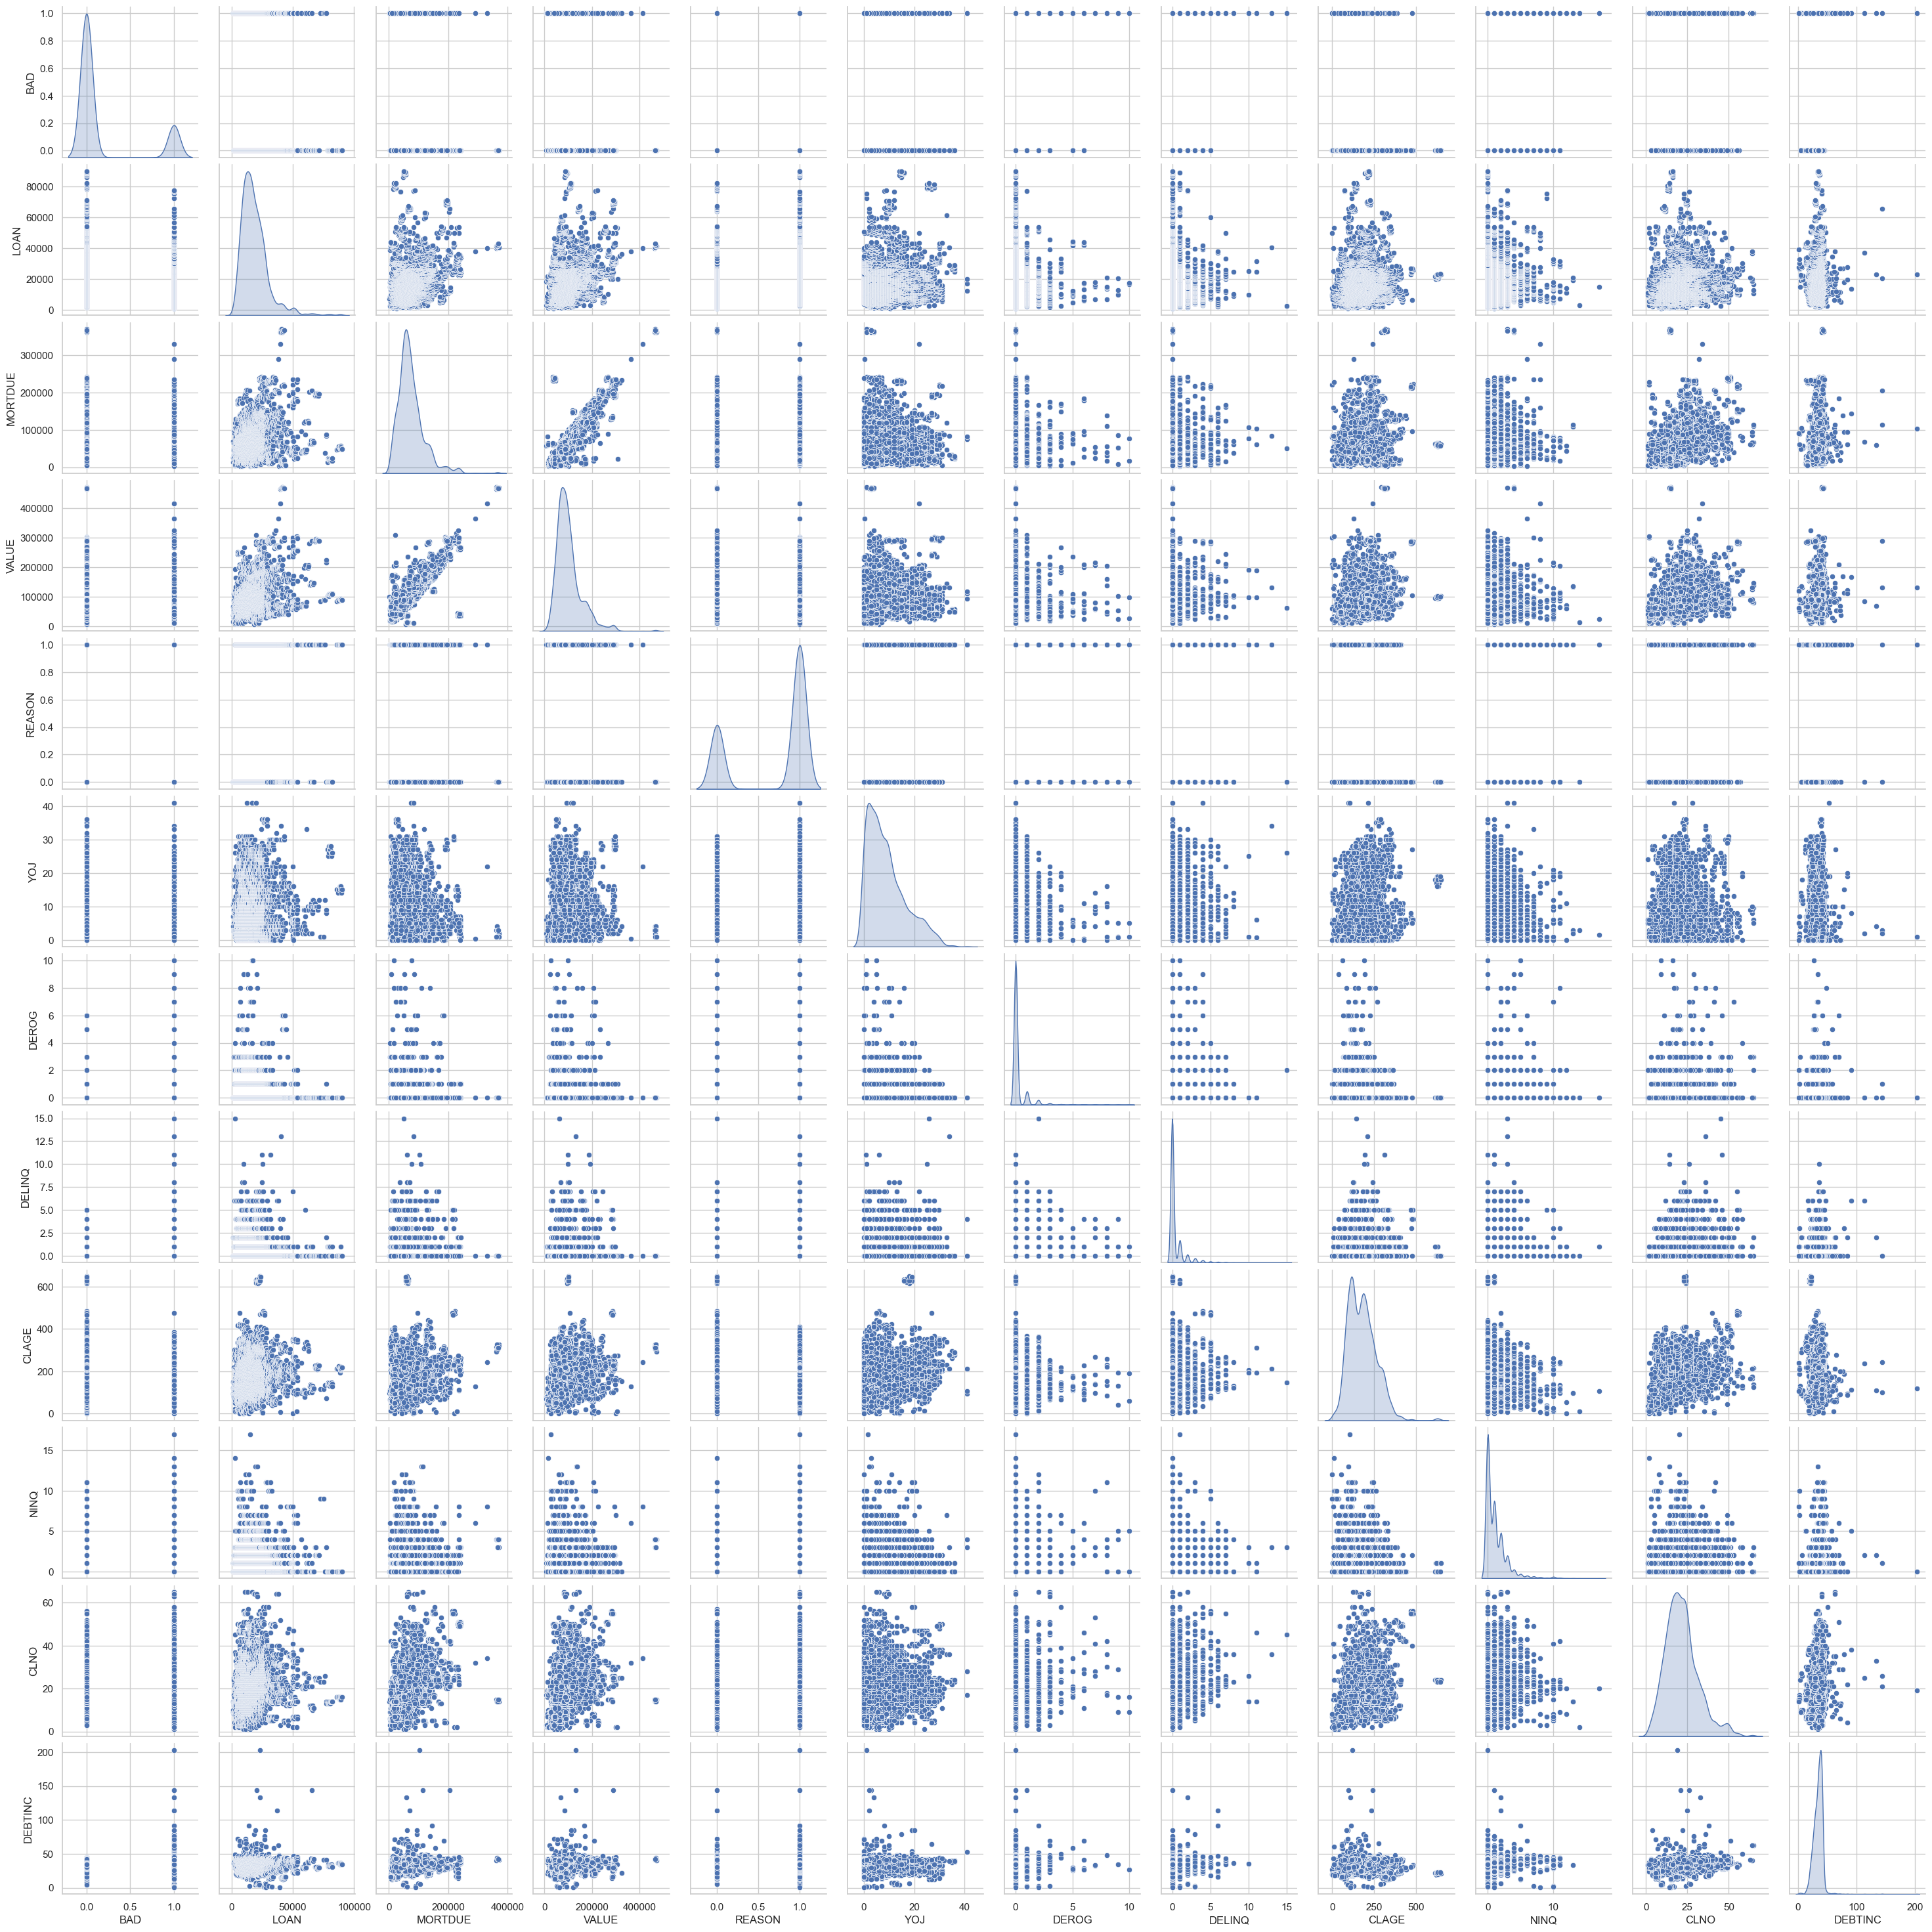

In [22]:
# Stratégie de qualité des données
sns.pairplot(df[df.columns], diag_kind='kde')
plt.show()

Ce qui précède nous indique les relations entre les variables pour identifier les corrélations potentielles. Il y a une linéarité entre VALUE et MORTDUE, autrement dit entre la valeur de la propriété et le montant du sur l'hypothèque : il est censé d'utiliser cette observation dans le remplacement des valeurs manquantes.

In [23]:
# Création d'un résumé des colonnes avec gestion des valeurs manquantes
resume = []

for col in df.columns:
    nb_missing = df[col].isnull().sum()
    mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else np.nan
    nb_modalities = df[col].nunique()
    median_col = df[col].median() if df[col].dtype != object else 'string NaN'
    mean_col = df[col].mean() if df[col].dtype != object else 'string NaN'
    
    resume.append({'Nom_colonne': col, 
                        'Nb_valeurs_manquantes': nb_missing, 
                        'Valeur_modale': mode_value,
                        'Valeur_mediane': median_col, 
                        'Valeur_moyenne': mean_col,
                        'Nb_modalites': nb_modalities})

resume = pd.DataFrame(resume)
resume

Nom_colonne  Nb_valeurs_manquantes Valeur_modale Valeur_mediane  \
0          BAD                      0             0            0.0   
1         LOAN                      0         15000        16500.0   
2      MORTDUE                    349       42000.0        65000.0   
3        VALUE                      0       80000.0        90000.0   
4       REASON                    136           1.0            1.0   
5          JOB                    119         Other     string NaN   
6          YOJ                    333           0.0            7.0   
7        DEROG                    431           0.0            0.0   
8       DELINQ                    305           0.0            0.0   
9        CLAGE                      0         102.5      173.53321   
10        NINQ                    240           0.0            1.0   
11        CLNO                      0          19.0           20.0   
12     DEBTINC                   1106      0.838118      35.059327   

   Valeur_moyenne  Nb_modalites  
0        0.183355             2  
1    18781.010358           536  
2    73756.313326          4807  
3   102190.119578          5078  
4        0.692007             2  
5      string NaN             6  
6        9.018356            96  
7        0.238565            11  
8        0.430743            13  
9       179.53362          5202  
10       1.178225            16  
11      21.650009            60  
12      34.108044          4397

Cette cellule crée un résumé des colonnes, indiquant le nombre de valeurs manquantes, la valeur modale, la médiane, la moyenne et le nombre de modalités.

Nous pouvons appliquer la stratégie suivante :
- Pour 'MORTDUE' et 'VALUE', on utilise une régression linéaire
- Pour 'REASON', on observe si les NaN se rapprochent plus de 0 ou 1
- Pour 'JOB', on remplace par 'Other'
- Pour 'YOJ', 'DEROG', 'DELINQ', 'NINQ', et 'CLAGE', on remplace par 0 (valeur modale)
- Pour 'DEBTINC', on remplace par 33, conforme à la règle des 35% d'endettement maximum

In [24]:
# Stratégie de remplissage des valeurs manquantes
df['JOB'].fillna('Other', inplace=True)
df['REASON'].fillna(2, inplace=True)
df['YOJ'].fillna(0, inplace=True)
df['DEROG'].fillna(0, inplace=True)
df['DELINQ'].fillna(0, inplace=True)
df['NINQ'].fillna(0, inplace=True)
df['CLAGE'].fillna(0, inplace=True)
df['DEBTINC'].fillna(33, inplace=True)

In [25]:
# Conversion des types de données
df['BAD'] = df['BAD'].astype(int)
df['REASON'] = df['REASON'].astype(int)
df['YOJ'] = df['YOJ'].astype(int)
df['DEROG'] = df['DEROG'].astype(int)
df['DELINQ'] = df['DELINQ'].astype(int)
df['CLAGE'] = df['CLAGE'].astype(float)
df['NINQ'] = df['NINQ'].astype(int)
df['CLNO'] = df['CLNO'].astype(int)
df['DEBTINC'] = df['DEBTINC'].astype(int)

In [26]:
# Encodage des variables catégorielles
df = pd.get_dummies(df, columns=['JOB'], prefix=['JOB'])

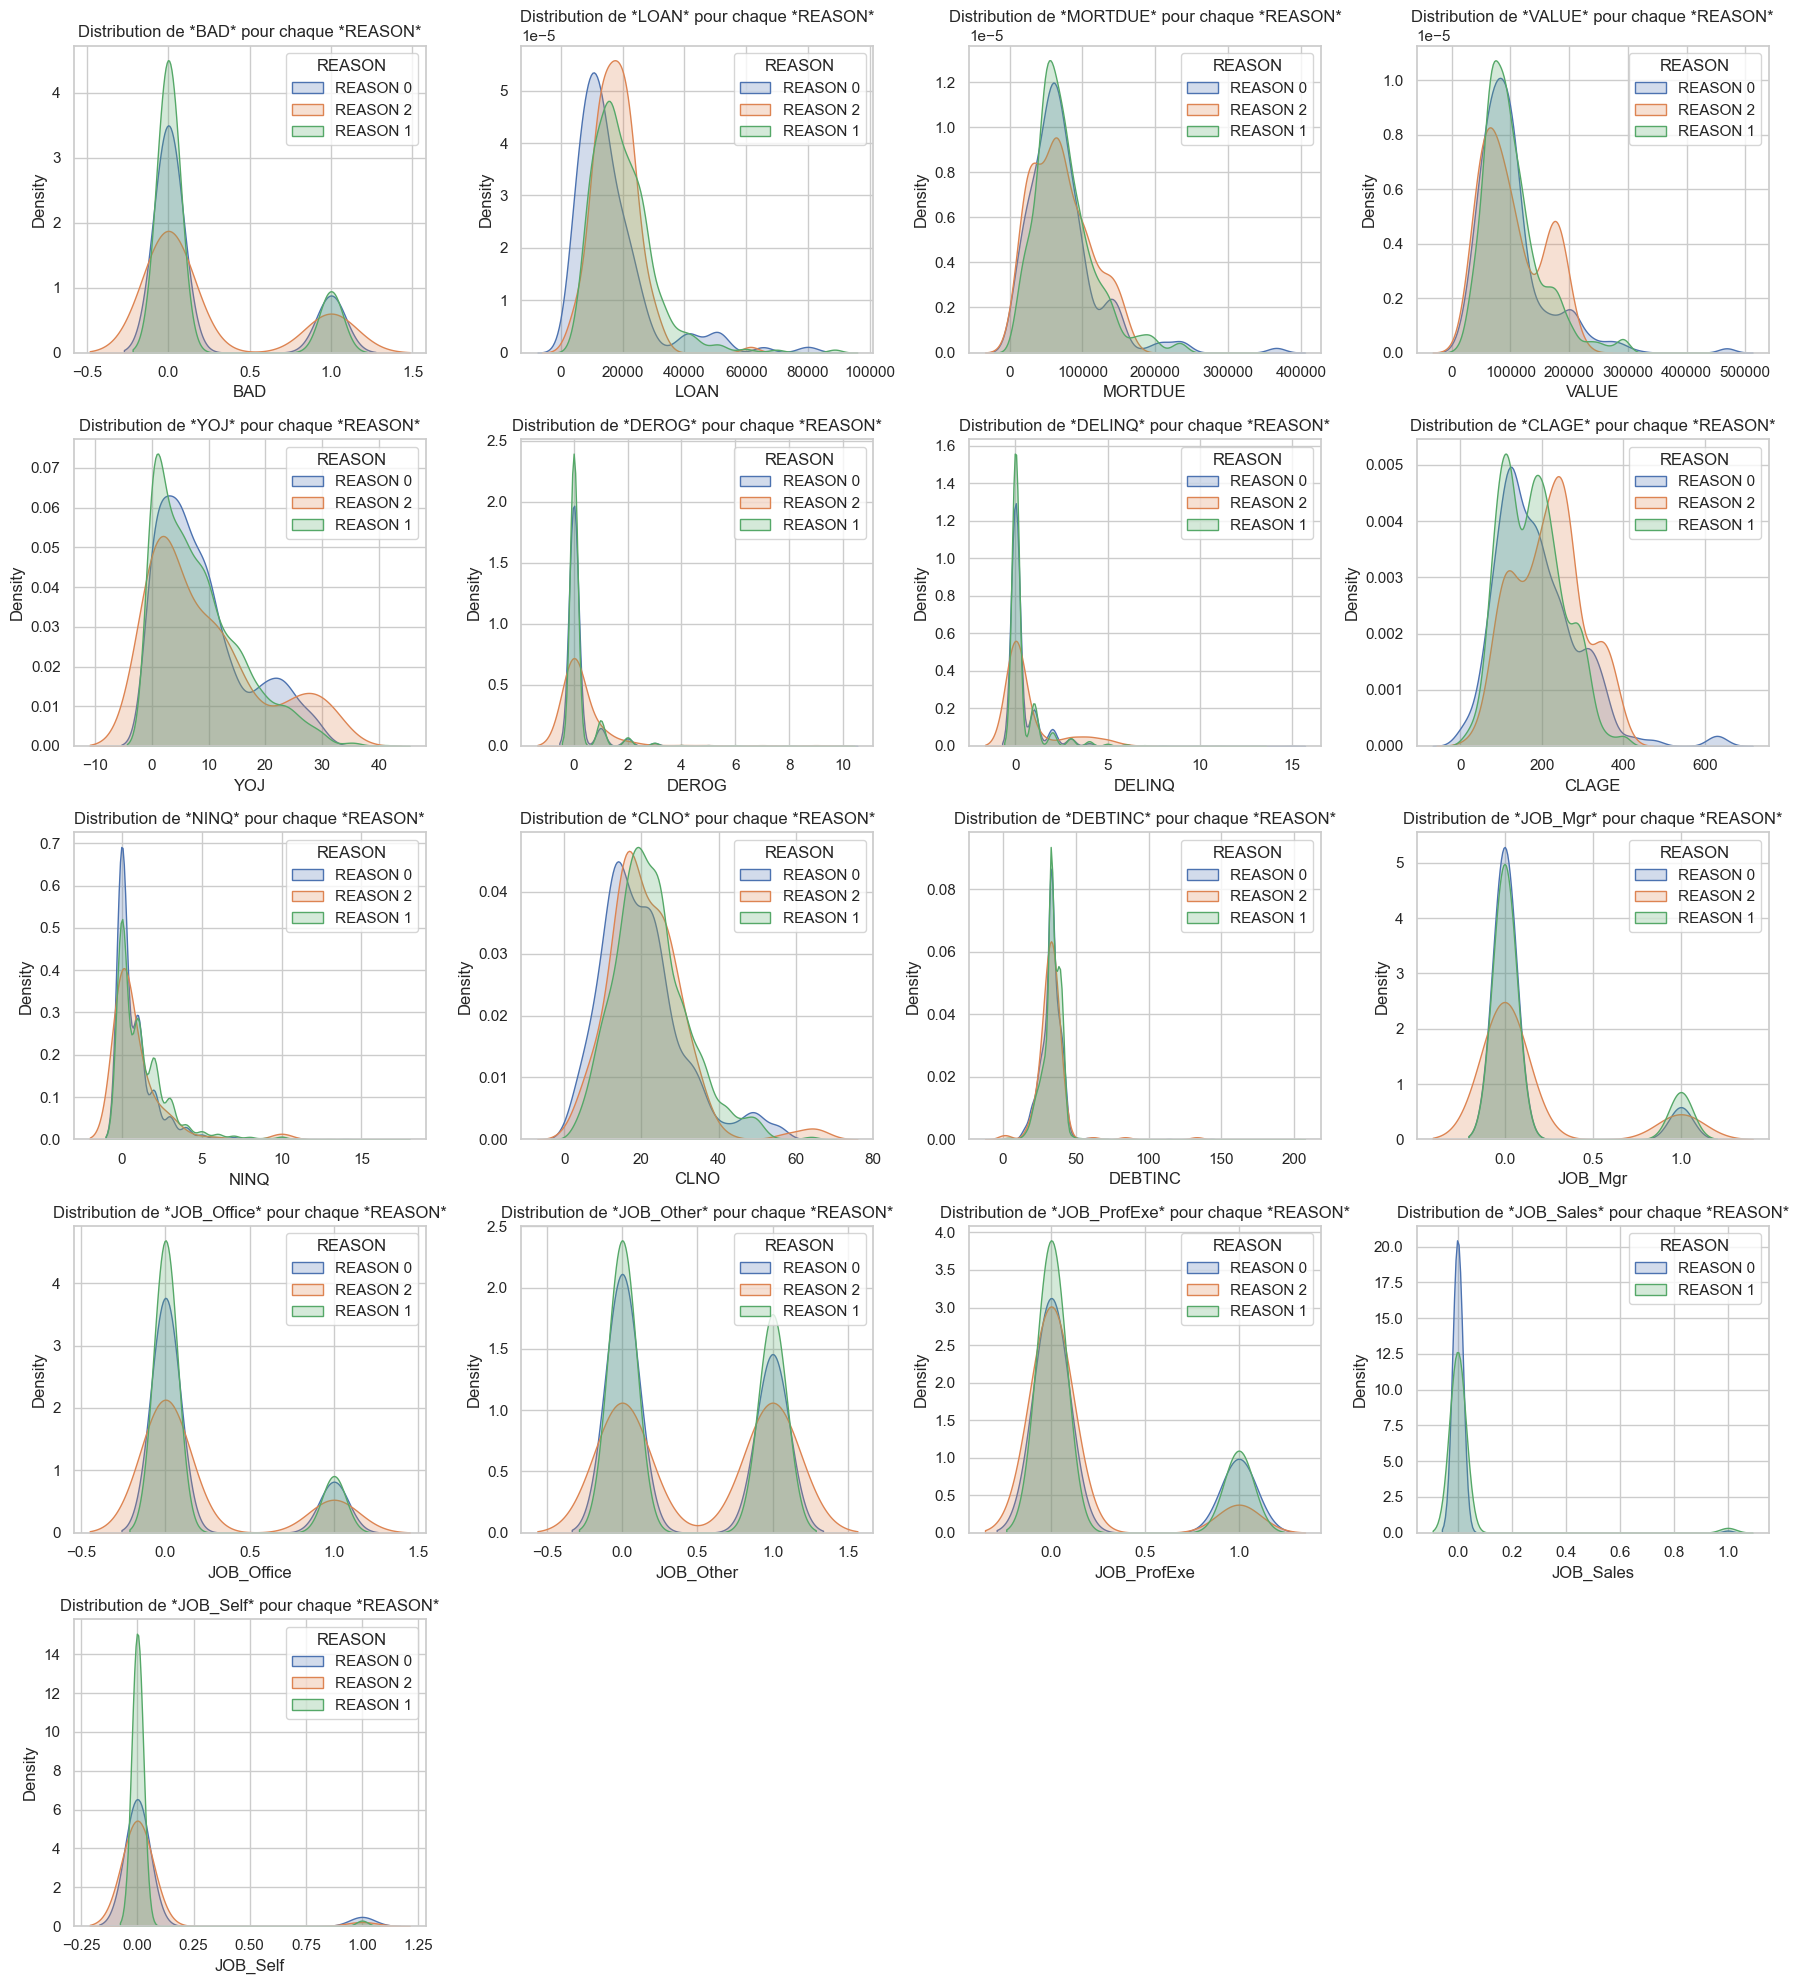

In [27]:
# Visualisation des distributions par niveau de 'REASON'
vars_to_plot = ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'JOB_Mgr', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']
num_cols = 4 
num_rows = (len(vars_to_plot) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4 * num_rows))

for i, variable in enumerate(vars_to_plot):
    row_idx = i // num_cols
    col_idx = i % num_cols

    for reason_level in df['REASON'].unique():
        subset = df[df['REASON'] == reason_level]
        sns.kdeplot(data=subset, x=variable, fill=True, label=f'REASON {reason_level}', ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_title(f'Distribution de *{variable}* pour chaque *REASON*')
    axes[row_idx, col_idx].set_xlabel(variable)
    axes[row_idx, col_idx].set_ylabel('Density')
    axes[row_idx, col_idx].legend(title='REASON', loc='upper right')

# Suppression des axes inutilisés
for i in range(len(vars_to_plot), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

En visualisant les distributions des variables par niveau de 'REASON', on observe les différences de comportement entre les différentes raisons de prêt : 'REASON 2' est légèrement plus proche de 'REASON 1' (*DebtCon*) que de 'REASON 0' (*HomeImp*), notamment sur les variables 'LOAN', 'VALUE' et 'YOJ'.

In [28]:
# Remplacement des valeurs manquantes pour 'REASON'
df['REASON'].replace(2, 1, inplace=True)
print("Valeurs uniques pour 'REASON' après remplacement :", df['REASON'].unique())

Valeurs uniques pour 'REASON' après remplacement : [0 1]


Nous décidons de remplacer les valeurs manquantes pour 'REASON' par la modalité la plus courante (valeur modale), *DebtCon*.

In [29]:
# Remplacement des valeurs aberrantes restantes par la médiane
median_value = df['VALUE'].median()
df['VALUE'].fillna(median_value, inplace=True)

# Suppression de la colonne 'MORTDUE' pour éviter la multicolinéarité
del df['MORTDUE']

# <span style="color:#943838;">Variables explicatives vs variable cible 'BAD'</span>

In [30]:
# Copie du DataFrame pour analyse
df_new=df.copy()
target='BAD'

## <span style="color:#389696;">Variables explicatives continues</span>

In [31]:
var_num = ['LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

In [32]:
# Test de Student pour déterminer la significativité des variables explicatives continues
for v in var_num:
    a = list(df_new[df_new[target] == 0][v])
    b = list(df_new[df_new[target] == 1][v])
    st_test, st_p = ss.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='omit')
    print(v + ": p-value test Student = " + str(st_p))

LOAN: p-value test Student = 1.4007205825811841e-11
VALUE: p-value test Student = 2.504554924681011e-07
YOJ: p-value test Student = 2.1890733763473083e-07
DEROG: p-value test Student = 1.467005752734604e-32
DELINQ: p-value test Student = 6.113349274085567e-52
CLAGE: p-value test Student = 1.2758103667711593e-48
NINQ: p-value test Student = 2.098473054086312e-29
CLNO: p-value test Student = 0.8103721222005962
DEBTINC: p-value test Student = 9.782143151716772e-10


On procède à des tests de Student pour déterminer si telle variable quantitative est liée à la variable cible 'BAD'. Ici, seule 'CLNO' semble ne pas être liée à la variable cible au seuil de 5%.

## <span style="color:#389696;">Variables explicatives qualitatives</span>

In [33]:
# Fonction pour calculer le V de Cramer entre deux variables
def cramers(var1: str, var2: str, dataframe):
    crosstab = pd.crosstab(dataframe[var1], dataframe[var2], rownames=[var1], colnames=[var2])
    chi2 = ss.chi2_contingency(crosstab)[0]
    n = sum(crosstab.sum())
    prob_chi2 = round(ss.chi2_contingency(crosstab)[1], 4)
    if prob_chi2 < 0.0001: prob_chi2 = '< 0.0001'
    return var1, var2, round(abs(np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))), 3), round(chi2, 3), prob_chi2

In [34]:
# Fonction pour calculer le V de Cramer entre chaque variable catégorielle et la variable cible
def vcramers_target(list_var_category: list, target: str, dataframe):
    res = []
    for var in list_var_category:
        res.append(cramers(var, target, dataframe))
    resultat_final = pd.DataFrame(res, columns=['Variable', 'Variable 2', 'abs_V_cramer', 'Chi2', 'Prob Chi2'])
    resultat_final = resultat_final.drop('Variable 2', axis=1).sort_values('abs_V_cramer', ascending=False)
    return resultat_final

In [35]:
# Transformation des variables qualitatives en format analysable
df_new['analyse_job'] = df_new.filter(like='JOB_').idxmax(axis=1).str.replace('JOB_', '')
df_new['analyse_reason'] = df_new['REASON'].replace({0: 'HomeImp', 1: 'DebtCon'})

In [36]:
# Calcul du V de Cramer pour les variables catégorielles
df_vcramers_target = vcramers_target(['analyse_job', 'analyse_reason'], target, df_new)
print(df_vcramers_target)

         Variable  abs_V_cramer    Chi2 Prob Chi2
0     analyse_job         0.121  80.513  < 0.0001
1  analyse_reason         0.029   4.663    0.0308


## <span style="color:#389696;">Sélection de variables avec pénalisation</span>

In [37]:
# Liste des variables pour la modélisation
liste_var = ['LOAN', 'VALUE', 'REASON', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'DEBTINC', 'JOB_Mgr', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']

In [38]:
# Définition des variables explicatives et cible
X = df_new[liste_var]
y = df_new['BAD']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Recherche de l'alpha optimal (lambda) pour LASSO avec validation croisée
alphas = np.logspace(-4, 2, 100)
lasso_cv_model = LassoCV(alphas=alphas, cv=5)
lasso_cv_model.fit(X_train_scaled, y_train)

# Alpha optimal
best_alpha = lasso_cv_model.alpha_
print("Optimal alpha (lambda):", best_alpha)

Optimal alpha (lambda): 0.0001


In [39]:
# Vérification des formes et types des ensembles d'entraînement
print("X_train shape:", X_train_scaled.shape, " | Type:", type(X_train_scaled))
print("y_train shape:", y_train.shape, " | Type:", type(y_train))

X_train shape: (4402, 15)  | Type: <class 'numpy.ndarray'>
y_train shape: (4402,)  | Type: <class 'pandas.core.series.Series'>


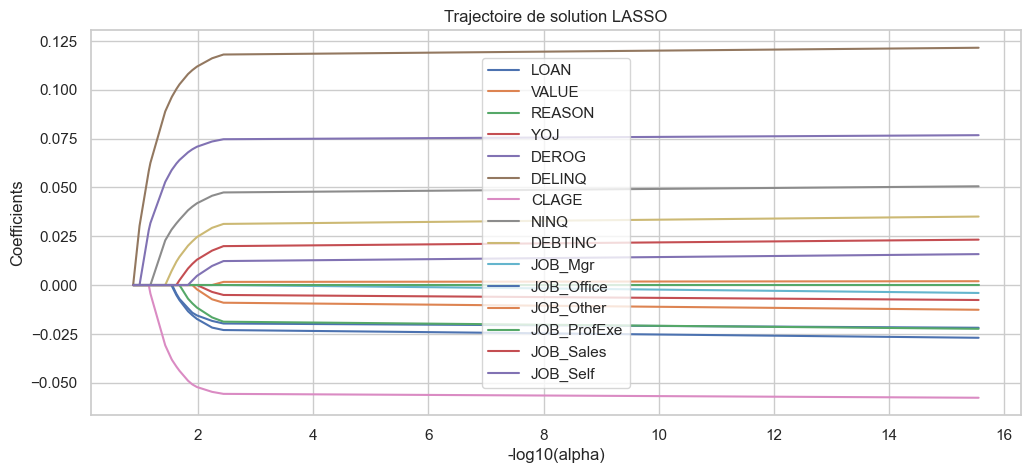

In [40]:
# Trajectoire de solution LASSO
alphas, _, coefs = lars_path(X_train_scaled, y_train.values.flatten(), method='lasso')

feature_names = X.columns
plt.figure(figsize=(12, 5))
neg_log_alphas_lasso = -np.log10(alphas)
for i in range(coefs.shape[0]):
    plt.plot(neg_log_alphas_lasso, coefs[i], label=feature_names[i])
plt.xlabel('-log10(alpha)')
plt.ylabel('Coefficients')
plt.title('Trajectoire de solution LASSO')
plt.legend()
plt.show()

In [41]:
# Fonction pour l'entraînement LASSO et extraction des coefficients
def LASSO(X, y, alpha, test_size=0.2, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    coefficients = lasso.coef_
    coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': abs(coefficients)})
    largest_coeffs_abs = coefficients_df.nlargest(10, 'Coefficient').reset_index(drop=True)
    return largest_coeffs_abs

# Utilisation de la fonction LASSO
coefficients_table_LASSO = LASSO(X, y, alpha=best_alpha, test_size=0.2, random_state=0)
coefficients_table_LASSO

Variable  Coefficient
0       DELINQ     0.112436
1    JOB_Sales     0.111113
2        DEROG     0.094218
3   JOB_Office     0.068929
4     JOB_Self     0.048919
5       REASON     0.030761
6         NINQ     0.028469
7  JOB_ProfExe     0.013487
8      JOB_Mgr     0.012969
9      DEBTINC     0.004324

In [42]:
# Fonction pour l'entraînement ElasticNet et extraction des coefficients
def ELASTIC_NET(X, y, alpha, l1_ratio, test_size=0.2, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net.fit(X_train, y_train)
    coefficients = elastic_net.coef_
    coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': abs(coefficients)})
    largest_coeffs_abs = coefficients_df.nlargest(10, 'Coefficient').reset_index(drop=True)
    return largest_coeffs_abs

# Utilisation de la fonction ElasticNet
coefficients_table_ELASTIC_NET = ELASTIC_NET(X, y, alpha=best_alpha, l1_ratio=0.5, test_size=0.2, random_state=0)
coefficients_table_ELASTIC_NET

Variable  Coefficient
0       DELINQ     0.112474
1    JOB_Sales     0.110749
2        DEROG     0.094257
3   JOB_Office     0.071862
4     JOB_Self     0.047663
5       REASON     0.030958
6         NINQ     0.028493
7  JOB_ProfExe     0.016371
8      JOB_Mgr     0.015992
9      DEBTINC     0.004323

In [43]:
# Fusion des résultats LASSO et ElasticNet pour trouver les variables communes
common_variables = pd.merge(coefficients_table_LASSO, coefficients_table_ELASTIC_NET, on=['Variable'], how='inner')
new_column_names = {'Coefficient_x': 'Coefficient LASSO', 'Coefficient_y': 'Coefficient ELASTIC-NET'}
common_variables.rename(columns=new_column_names, inplace=True)

# Nombre de variables communes
num_common_rows = common_variables.shape[0]
print(f"Il y a {num_common_rows} variables communes au LASSO et à l'ELASTIC-NET. \n")

# Affichage des variables communes
print(common_variables)

Il y a 10 variables communes au LASSO et à l'ELASTIC-NET. 

      Variable  Coefficient LASSO  Coefficient ELASTIC-NET
0       DELINQ           0.112436                 0.112474
1    JOB_Sales           0.111113                 0.110749
2        DEROG           0.094218                 0.094257
3   JOB_Office           0.068929                 0.071862
4     JOB_Self           0.048919                 0.047663
5       REASON           0.030761                 0.030958
6         NINQ           0.028469                 0.028493
7  JOB_ProfExe           0.013487                 0.016371
8      JOB_Mgr           0.012969                 0.015992
9      DEBTINC           0.004324                 0.004323


Nous avons identifié 10 variables communes qui peuvent être utilisées pour la modélisation. Ces variables sont potentiellement les plus influentes pour prédire la variable cible 'BAD'.

# <span style="color:#943838;">Modélisation des données</span>

Pour répondre aux exigences de l'Equal Credit Opportunity Act, nous avons choisi d'implémenter **trois modèles de prédiction axés sur l'interprétabilité**, ainsi qu'un modèle supplémentaire basé sur une approche davantage "boîte noire" mais avec des techniques d'explication avancées.

Les modèles sélectionnés sont :
1. La régression logistique
2. L'arbre de décision
3. Le classificateur k-NN

Ces modèles ont été choisis pour leur capacité à **fournir des explications claires et compréhensibles en cas de décisions défavorables, ce qui est crucial pour assurer la transparence et l'équité du processus d'approbation des crédits hypothécaires**.

En complément, nous déployons également un **modèle XGBoost**, reconnu pour ses performances élevées, tout en utilisant les **valeurs de Shapley pour expliciter les décisions prises** par ce modèle complexe. Les valeurs de Shapley permettent de décomposer les prédictions en contributions individuelles de chaque variable, offrant ainsi une compréhension détaillée même dans le cadre d'un modèle initialement opaque. Cette approche combinée nous assure non seulement de respecter les normes réglementaires mais aussi de maintenir un haut niveau de performance prédictive.

In [44]:
# Liste des variables sélectionnées pour la modélisation
liste_var = common_variables['Variable'].tolist()

# Définition des variables explicatives et de la variable cible
X = df_new[liste_var]
y = df_new['BAD']

## <span style="color:#389696;">Matrice de corrélations</span>

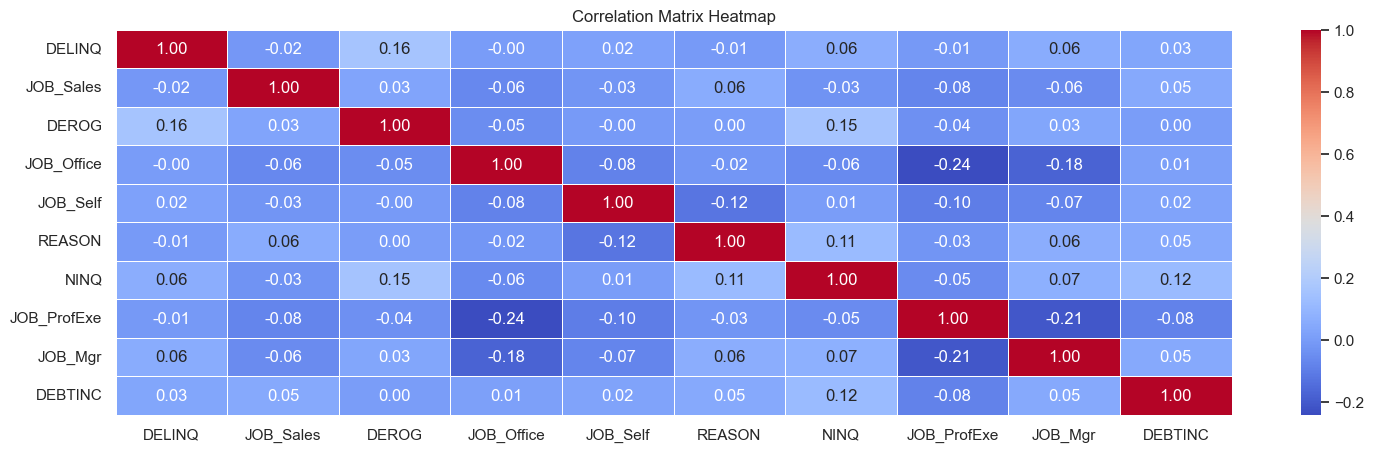

In [45]:
# Calcul de la matrice de corrélations entre les variables explicatives
correlation_matrix = X.corr()

# Visualisation de la matrice de corrélations
plt.figure(figsize=(18, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Nous avons utilisé les variables communes identifiées entre les modèles LASSO et ElasticNet pour la modélisation. Une matrice de corrélations a été calculée et visualisée pour s'assurer qu'il n'y a pas de corrélations fortes entre les variables explicatives, ce qui pourrait entraîner des problèmes de multicolinéarité dans les modèles prédictifs. La visualisation montre qu'il n'y a pas de corrélation significative entre les variables explicatives, confirmant ainsi leur indépendance relative.

## <span style="color:#389696;">Modèle N°1 : Régression Logistique</span>

### Normalisation des variables continues et séparation des données

In [46]:
# Normalisation des variables continues
scaler = StandardScaler()
var_num = ['DELINQ', 'DEROG', 'REASON', 'NINQ', 'DEBTINC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

scaler.fit(X_train[var_num])
X_train_norm[var_num] = scaler.transform(X_train[var_num])
X_test_norm[var_num] = scaler.transform(X_test[var_num])

Les variables continues sont normalisées.

### Définition des espaces de recherche pour les paramètres et recherche des hyperparamètres optimaux

In [47]:
# Définition des espaces de recherche pour les paramètres avec GridSearchCV
param_grid_l1 = {
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga'],
    'tol': np.linspace(0.0001, 1, 10),
    'C': np.linspace(0.01, 0.9, 10)
}

param_grid_l2 = {
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'tol': np.linspace(0.0001, 1, 10),
    'C': np.linspace(0.01, 0.99, 10)
}

param_grid_elasticnet = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': np.linspace(0.01, 0.99, 10),
    'tol': np.linspace(0.0001, 1, 10),
    'C': np.linspace(0.01, 0.99, 10)
}

param_grid = [param_grid_l1, param_grid_l2, param_grid_elasticnet]

# Initialisation et recherche des hyperparamètres optimaux
opt = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

start = timer()
opt.fit(X_train_norm, y_train)
delais = timer() - start

print("#### RECHERCHE DES PARAMETRES OPTIMAUX POUR LA REGRESSION LOGISTIQUE ####")
print(f"Durée de recherche en secondes : {delais}")
print(f"Paramètres optimaux : {opt.best_params_}")
print(f"Meilleur score : {opt.best_score_}")

#### RECHERCHE DES PARAMETRES OPTIMAUX POUR LA REGRESSION LOGISTIQUE ####
Durée de recherche en secondes : 56.47365920000084
Paramètres optimaux : {'C': 0.30666666666666664, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.33340000000000003}
Meilleur score : 0.7848401569501728


On trouve les meilleurs hyperparamètres pour différents types de régression logistique (L1, L2, ElasticNet).

### Entraînement du modèle avec les paramètres optimaux et extraction des coefficients

In [48]:
# Entraînement du modèle avec les paramètres optimaux
reg_log = LogisticRegression(**opt.best_params_)
reg_log.fit(X_train_norm, y_train)

# Extraction des coefficients
table_coeff = pd.DataFrame({
    'Variable': X_train_norm.columns,
    'Coefficient': reg_log.coef_[0]
})
print(table_coeff)

      Variable  Coefficient
0       DELINQ     0.774013
1    JOB_Sales     0.193451
2        DEROG     0.481911
3   JOB_Office    -0.714065
4     JOB_Self     0.032846
5       REASON    -0.156820
6         NINQ     0.393142
7  JOB_ProfExe    -0.265069
8      JOB_Mgr    -0.244206
9      DEBTINC     0.270285


Le modèle est entraîné avec les meilleurs paramètres trouvés et les coefficients sont extraits.

### Prédiction et calcul des probabilités

In [49]:
# Prédiction et calcul des probabilités
y_train_predict_proba_RL = reg_log.predict_proba(X_train_norm)[:, 1]
y_test_predict_proba_RL = reg_log.predict_proba(X_test_norm)[:, 1]

# Évaluation des performances
print(f"Log Loss Apprentissage : {log_loss(y_train, y_train_predict_proba_RL)}")
print(f"Log Loss Test : {log_loss(y_test, y_test_predict_proba_RL)}")

Log Loss Apprentissage : 0.3804311612338965
Log Loss Test : 0.39327021487592406


Les prédictions et les probabilités sont calculées, et les métriques de performance sont affichées.

### Courbes ROC et Precision-Recall

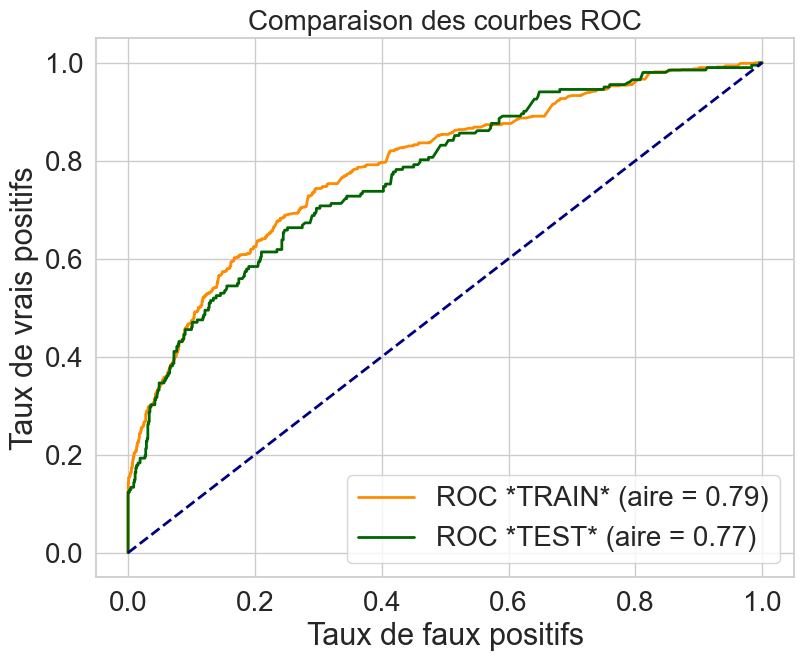

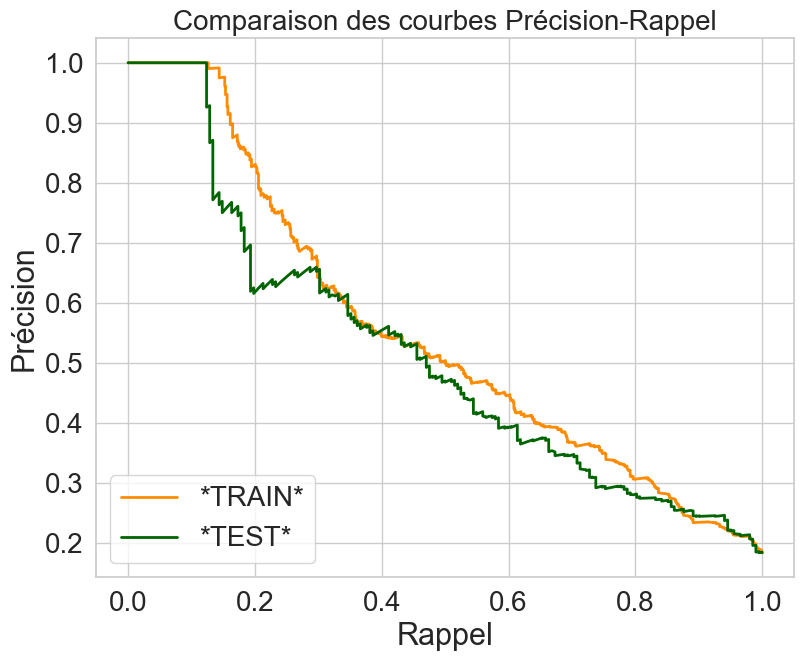

In [50]:
# Paramètres de graphisme
def param_graph(small=20, medium=22, big=25):
    plt.figure(figsize=(9, 7))
    plt.rc('font', size=small)
    plt.rc('axes', titlesize=small)
    plt.rc('axes', labelsize=medium)
    plt.rc('xtick', labelsize=small)
    plt.rc('ytick', labelsize=small)
    plt.rc('legend', fontsize=small)
    plt.rc('figure', titlesize=big)

# Calcul des courbes ROC et Precision-Recall
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_predict_proba_RL)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba_RL)
roc_auc_train = roc_auc_score(y_train, y_train_predict_proba_RL)
roc_auc_test = roc_auc_score(y_test, y_test_predict_proba_RL)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_predict_proba_RL)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_predict_proba_RL)

# Courbe ROC
param_graph()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC *TRAIN* (aire = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkgreen', lw=2, label=f'ROC *TEST* (aire = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Comparaison des courbes ROC')
plt.legend(loc="lower right")
plt.show()

# Courbe Precision-Recall
param_graph()
plt.plot(recall_train, precision_train, color='darkorange', lw=2, label='*TRAIN*')
plt.plot(recall_test, precision_test, color='darkgreen', lw=2, label='*TEST*')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Comparaison des courbes Précision-Rappel')
plt.legend(loc="lower left")
plt.show()

Les courbes ROC et Précision-Rappel sont tracées pour évaluer les performances du modèle.

### Tableau de seuil et téléchargement du fichier CSV

In [51]:
# Tableau de choix de seuil
table_choix_seuil = pd.DataFrame({
    'SEUIL': [0] + list(thresholds_test),
    'Precision_test': precision_test,
    'Recall_test': recall_test
}).sort_values(by="SEUIL", ascending=False)

# Création du lien de téléchargement
def create_download_link(df, title="Download CSV file", filename="data.csv"):
    csv = df.to_csv(sep=';', index=False, decimal=',')
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = f'<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    return HTML(html)

create_download_link(table_choix_seuil, title="Télécharger le fichier csv", filename="seuils_RL.csv")

<div class="alert alert-block alert-info">
<b></b> Deux approches pour sélectionner un modèle et le seuil :
 <br>1. Approche statistique : maximiser un critère tel que l'AUC, F1-Score
 <br>2. Approche métier : arbitrer entre précision et recall, utiliser le lift, ...
</div>

### Courbe Lift et analyse des résultats de la régression logistique

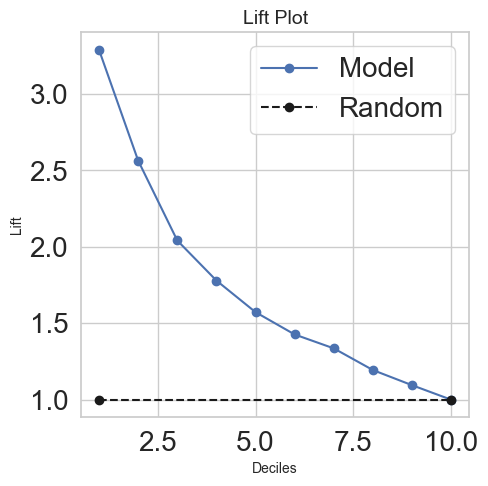

In [52]:
# Courbe Lift
plt.figure(figsize=(5, 5))
kds.metrics.plot_lift(y_test, y_test_predict_proba_RL)
plt.show()

In [53]:
# Conversion des colonnes booléennes en numériques
X_train_norm = X_train_norm.astype({col: 'int' for col in X_train_norm.select_dtypes('bool').columns})

In [54]:
# Régression logistique avec statsmodels
lr = Logit(endog=y_train, exog=X_train_norm)
reg = lr.fit()
print(reg.summary())

Optimization terminated successfully.
         Current function value: 0.458662
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4402
Model:                          Logit   Df Residuals:                     4392
Method:                           MLE   Df Model:                            9
Date:                Sat, 25 May 2024   Pseudo R-squ.:                 0.03723
Time:                        10:58:33   Log-Likelihood:                -2019.0
converged:                       True   LL-Null:                       -2097.1
Covariance Type:            nonrobust   LLR p-value:                 4.671e-29
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
DELINQ          0.8578      0.049     17.475      0.000       0.762       0.954
JOB_Sales      -0.5477    

Ce qui suit nous permet de mieux comprendre les facteurs de risque associés au défaut de paiement et à améliorer les modèles prédictifs futurs.

**Résumé des Résultats**

- Convergence du Modèle : La régression logistique a convergé après 7 itérations, ce qui signifie que l'optimisation s'est bien terminée.
- Log-Likelihood : La valeur du Log-Likelihood est de -1667.3, et la Pseudo R-squ. est de 0.2050, ce qui indique que le modèle explique environ 20,5% de la variabilité dans les données. Le Log-Likelihood initial (LL-Null) était de -2097.1.
- LLR p-value : La p-value du test du Log-Likelihood ratio est extrêmement faible (3.038e-178), indiquant que le modèle est significativement meilleur que le modèle nul.

**Interprétation des Coefficients**

- DELINQ (0.7843) : Le coefficient est significatif (p-value < 0.0001) et positif, ce qui signifie qu'une augmentation du nombre de litiges est associée à une augmentation de la probabilité de défaut.
- JOB_Sales (1.0175) : Les individus ayant un emploi dans la vente ont une probabilité significativement plus élevée de défaut par rapport à ceux ayant d'autres emplois de référence (p-value < 0.0001).
- DEROG (0.5123) : Le nombre de demandes de reports d'échéances de prêts a un coefficient positif et significatif (p-value < 0.0001), indiquant que plus ce nombre est élevé, plus la probabilité de défaut augmente.
- JOB_Office (-0.7759) : Les individus ayant un emploi dans le secteur administratif ont une probabilité significativement plus faible de défaut (p-value < 0.0001).
- JOB_Self (0.2212) : Le coefficient pour les travailleurs indépendants n'est pas significatif (p-value = 0.339), ce qui signifie que ce facteur n'a pas d'impact significatif sur la probabilité de défaut.
- REASON (-0.1937) : Le motif du prêt a un coefficient négatif et significatif (p-value < 0.0001), indiquant que les prêts pour consolidation financière (valeur 1) sont associés à une probabilité de défaut plus faible que les prêts pour amélioration de l'habitat (valeur 0).
- NINQ (0.3670) : Le nombre de demandes récentes de crédit est positivement et significativement associé à la probabilité de défaut (p-value < 0.0001).
- JOB_ProfExe (-0.2816) : Les individus ayant un emploi professionnel ou exécutif ont une probabilité significativement plus faible de défaut (p-value = 0.019).
- JOB_Mgr (-0.2988) : Les managers ont une probabilité significativement plus faible de défaut (p-value = 0.026).
- DEBTINC (0.3334) : Le ratio dette sur revenu est significativement et positivement associé à la probabilité de défaut (p-value < 0.0001).
- const (-1.5489) : La constante est significative (p-value < 0.0001), indiquant qu'il existe un effet de base important sur la probabilité de défaut lorsqu'aucune autre variable n'est prise en compte.

**Conclusion**

- La majorité des variables explicatives sont significatives et ont un impact clair sur la probabilité de défaut.
- Les coefficients positifs indiquent une augmentation de la probabilité de défaut, tandis que les coefficients négatifs indiquent une diminution de cette probabilité.
- Le modèle semble bien ajusté pour prédire le défaut de paiement basé sur les variables fournies, bien qu'il y ait toujours une part importante de variabilité non expliquée.

## <span style="color:#389696;">Modèle n°2 : Arbre de Décision</span>

### Définition de l'espace de recherche pour les hyperparamètres

In [55]:
# Définition de la grille des hyperparamètres pour l'arbre de décision
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

### Recherche des hyperparamètres optimaux avec GridSearchCV

In [56]:
# Instanciation du modèle de recherche par validation croisée
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Recherche des hyperparamètres optimaux
start = timer()
grid_search.fit(X_train_norm, y_train)
delais = timer() - start

# Affichage des résultats
print("#### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE DECISION TREE ####")
print("\nDurée de recherche en seconde :", delais)
print("\nParamètres optimaux :")
best_param_opti_grid = grid_search.best_params_
print(best_param_opti_grid)
best_score_opti_grid = grid_search.best_score_
print("\nMeilleur score : " + str(best_score_opti_grid))

#### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE DECISION TREE ####

Durée de recherche en seconde : 18.910649900000863

Paramètres optimaux :
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20}

Meilleur score : 0.8622259838354509


### Entraînement du modèle avec les paramètres optimaux

In [57]:
# Construction du Decision Tree avec les paramètres optimaux
dt_clf = DecisionTreeClassifier(**grid_search.best_params_)
dt_clf.fit(X_train_norm, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_split=20)

### Évaluation du modèle et importance des variables

      Variable  Feature Importance
9      DEBTINC            0.581813
0       DELINQ            0.259906
2        DEROG            0.094167
6         NINQ            0.037070
7  JOB_ProfExe            0.009087
5       REASON            0.006908
3   JOB_Office            0.004004
1    JOB_Sales            0.003755
4     JOB_Self            0.003018
8      JOB_Mgr            0.000271

Log Loss Apprentissage : 0.2733516413663996
Log Loss Test : 0.3979129012560175


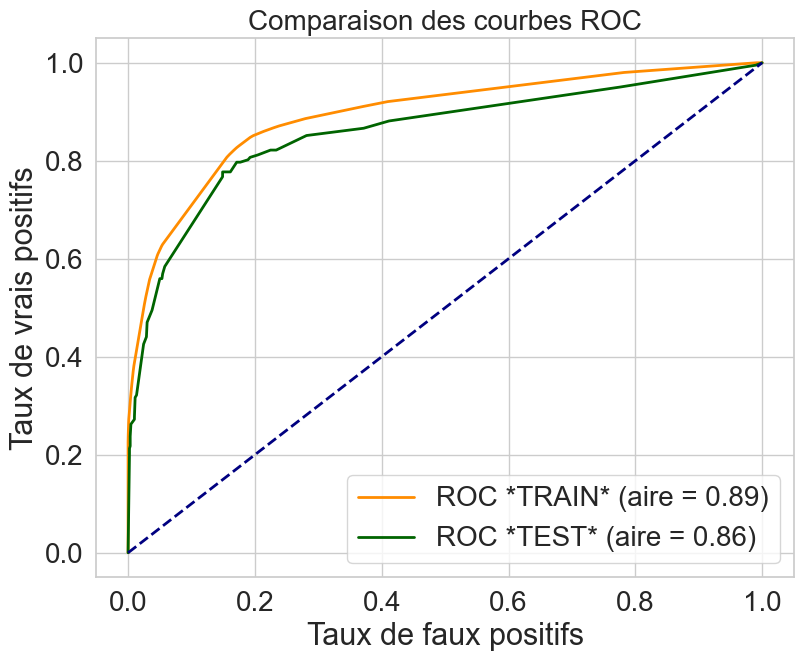

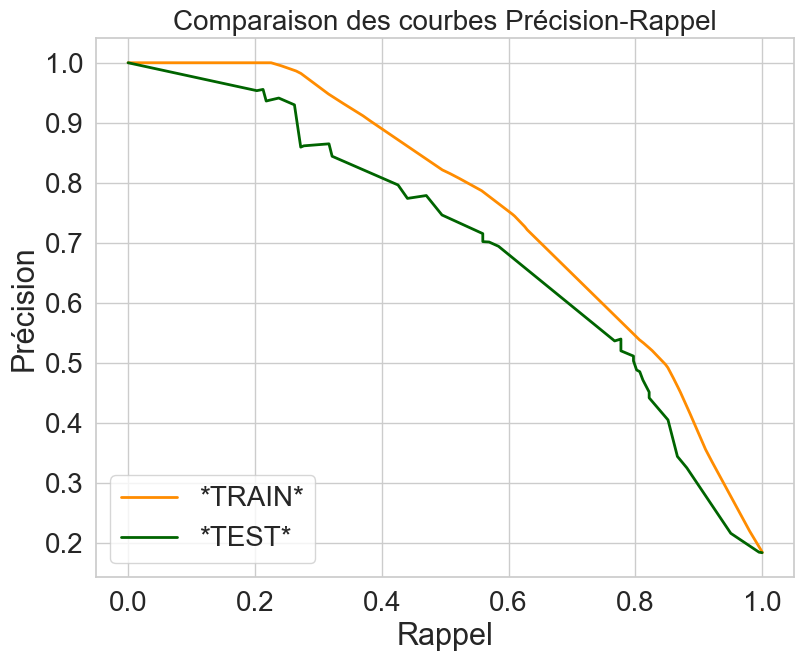

In [58]:
# Prédiction sur le jeu d'entraînement et de test
y_train_predict_proba_DT = dt_clf.predict_proba(X_train_norm)[:, 1]
y_test_predict_proba_DT = dt_clf.predict_proba(X_test_norm)[:, 1]

# Importance des variables
importance_variable_dt = pd.DataFrame()
importance_variable_dt["Variable"] = X_train_norm.columns
importance_variable_dt["Feature Importance"] = dt_clf.feature_importances_

# Affichage de l'importance des variables
print(importance_variable_dt.sort_values(by="Feature Importance", ascending=False))

# Calcul des courbes ROC et Precision-Recall pour Decision Tree
fpr_train_DT, tpr_train_DT, _ = roc_curve(y_train, y_train_predict_proba_DT)
fpr_test_DT, tpr_test_DT, _ = roc_curve(y_test, y_test_predict_proba_DT)
roc_auc_train_DT = roc_auc_score(y_train, y_train_predict_proba_DT)
roc_auc_test_DT = roc_auc_score(y_test, y_test_predict_proba_DT)

precision_train_DT, recall_train_DT, thresholds_train_DT = precision_recall_curve(y_train, y_train_predict_proba_DT)
precision_test_DT, recall_test_DT, thresholds_test_DT = precision_recall_curve(y_test, y_test_predict_proba_DT)

# Log loss pour Decision Tree
print("\nLog Loss Apprentissage : " + str(log_loss(y_train, y_train_predict_proba_DT)))
print("Log Loss Test : " + str(log_loss(y_test, y_test_predict_proba_DT)))

# Fonction de paramétrage des graphismes
def param_graph(small=20, medium=22, big=25):
    plt.figure(figsize=(9, 7))
    plt.rc('font', size=small)
    plt.rc('axes', titlesize=small)
    plt.rc('axes', labelsize=medium)
    plt.rc('xtick', labelsize=small)
    plt.rc('ytick', labelsize=small)
    plt.rc('legend', fontsize=small)
    plt.rc('figure', titlesize=big)

# Courbe ROC pour Decision Tree
param_graph()
plt.plot(fpr_train_DT, tpr_train_DT, color='darkorange', lw=2, label=f'ROC *TRAIN* (aire = {roc_auc_train_DT:.2f})')
plt.plot(fpr_test_DT, tpr_test_DT, color='darkgreen', lw=2, label=f'ROC *TEST* (aire = {roc_auc_test_DT:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Comparaison des courbes ROC')
plt.legend(loc="lower right")
plt.show()

# Courbe Precision-Recall pour Decision Tree
param_graph()
plt.plot(recall_train_DT, precision_train_DT, color='darkorange', lw=2, label='*TRAIN*')
plt.plot(recall_test_DT, precision_test_DT, color='darkgreen', lw=2, label='*TEST*')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Comparaison des courbes Précision-Rappel')
plt.legend(loc="lower left")
plt.show()

### Affichage de l'arbre de décision

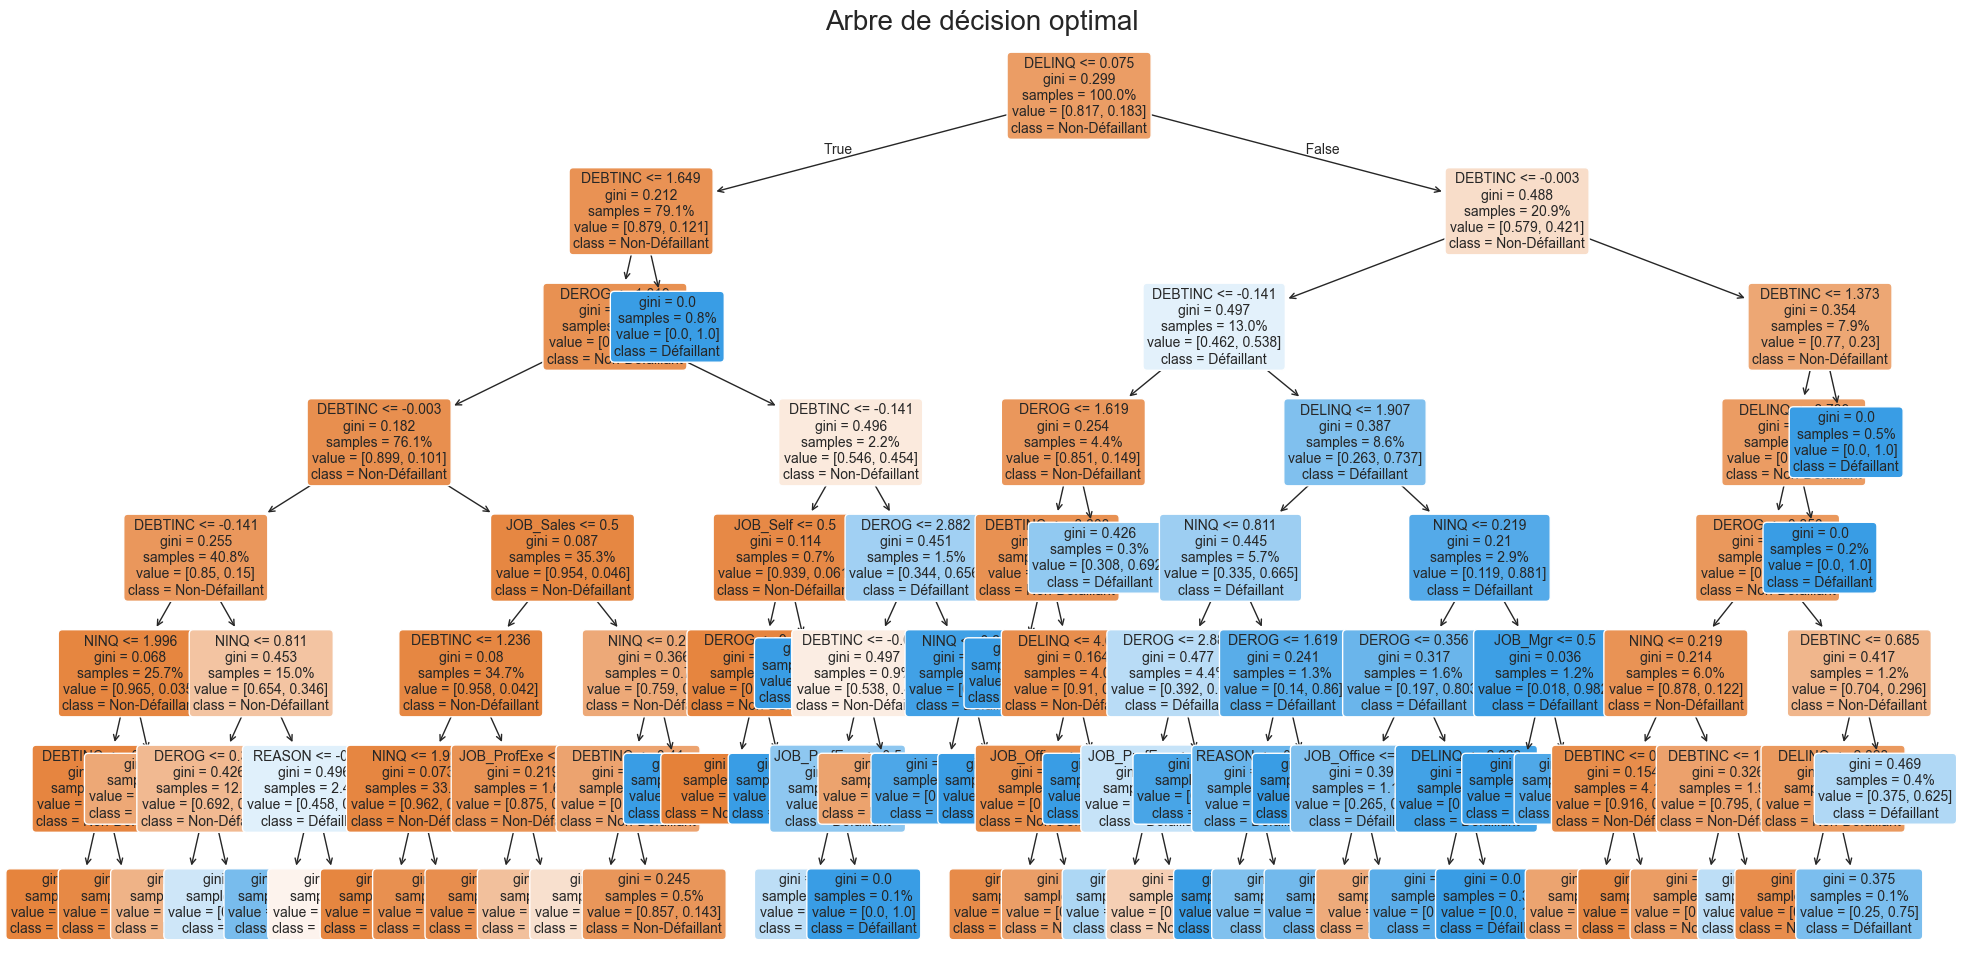

In [59]:
plt.figure(figsize=(24, 12))
plot_tree(dt_clf, 
          filled=True, 
          feature_names=X_train_norm.columns, 
          class_names=['Non-Défaillant', 'Défaillant'], 
          rounded=True, 
          fontsize=10,  # Taille de texte réduite pour une meilleure lisibilité
          proportion=True)  # Ajustement des proportions des nœuds en fonction du nombre d'échantillons
plt.title("Arbre de décision optimal")
plt.show()

**Quelques pistes de lecture sur l'importance des variables**

- Les variables les plus importantes pour prédire la défaillance sont 'DEBTINC', 'DELINQ' et 'DEROG'.
- La variable 'NINQ' a une certaine importance, mais elle est beaucoup moins influente que les autres caractéristiques principales.
- Les caractéristiques liées à la profession (comme 'JOB_ProfExe', 'JOB_Office', 'JOB_Sales', etc.) ont une importance très faible, ce qui suggère qu'elles contribuent peu à la prédiction de la défaillance dans ce modèle.
- La constante n'a aucune importance dans la classification, ce qui est attendu car elle ne varie pas et ne peut donc pas influencer la décision de l'arbre.

## <span style="color:#389696;">Modèle n°3 : KNN Classifier</span>

### Définition de l'espace de recherche pour les hyperparamètres

In [60]:
# Définir les hyperparamètres à rechercher
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

### Recherche des hyperparamètres optimaux avec GridSearchCV

In [61]:
# Instanciation du modèle de recherche par validation croisée
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Recherche des hyperparamètres optimaux
start = timer()
grid_search.fit(X_train_norm, y_train)
delais = timer() - start

# Affichage des résultats
print("#### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE KNN ####")
print("\nDurée de recherche en seconde :", delais)
print("\nParamètres optimaux :")
best_param_opti_grid = grid_search.best_params_
print(best_param_opti_grid)
best_score_opti_grid = grid_search.best_score_
print("\nMeilleur score : " + str(best_score_opti_grid))

#### RECHERCHE DES PARAMETRES OPTIMAUX POUR LE KNN ####

Durée de recherche en seconde : 9.323591500000475

Paramètres optimaux :
{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}

Meilleur score : 0.8345929060630456


### Entraînement du modèle avec les paramètres optimaux

In [62]:
# Construction du KNN avec les paramètres optimaux
knn_clf = KNeighborsClassifier(**best_param_opti_grid)
knn_clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=13)

### Évaluation du modèle et importance des variables

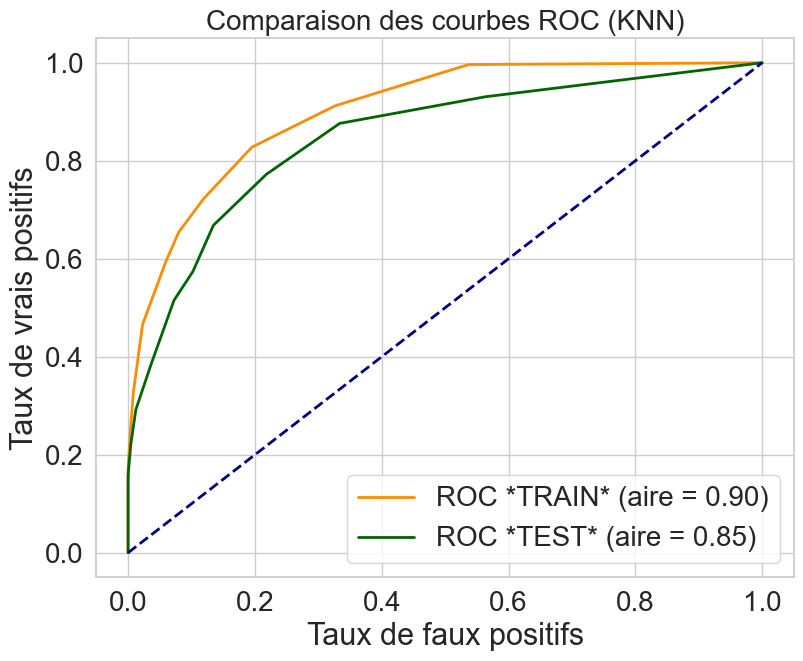

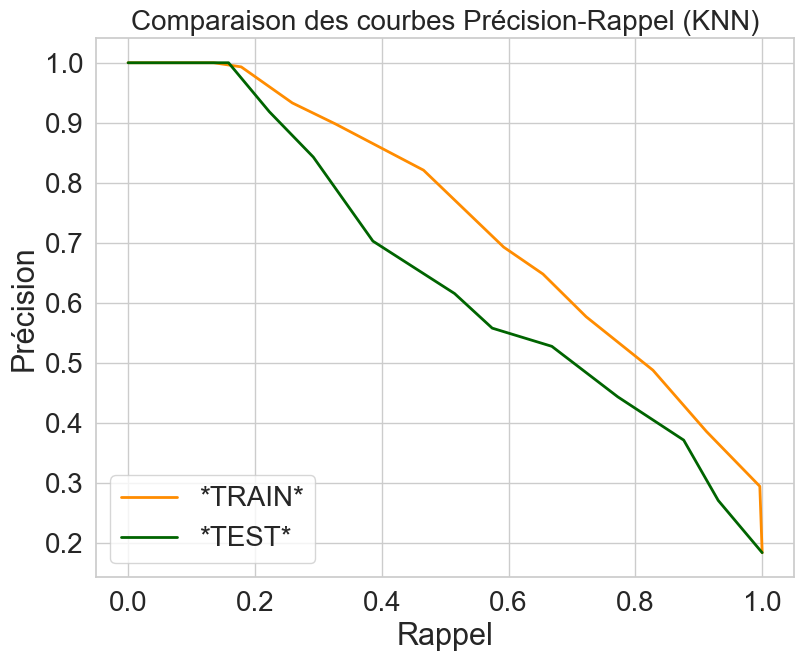

In [63]:
# Prédiction sur les ensembles d'entraînement et de test
y_train_predict_knn = knn_clf.predict(X_train_norm)
y_test_predict_knn = knn_clf.predict(X_test_norm)

# Probabilités prédites pour l'événement cible
y_train_predict_proba_knn = knn_clf.predict_proba(X_train_norm)[:, 1]
y_test_predict_proba_knn = knn_clf.predict_proba(X_test_norm)[:, 1]

# Calcul des courbes ROC et Precision-Recall
fpr_train_knn, tpr_train_knn, _ = roc_curve(y_train, y_train_predict_proba_knn)
fpr_test_knn, tpr_test_knn, _ = roc_curve(y_test, y_test_predict_proba_knn)
roc_auc_train_knn = roc_auc_score(y_train, y_train_predict_proba_knn)
roc_auc_test_knn = roc_auc_score(y_test, y_test_predict_proba_knn)

precision_train_knn, recall_train_knn, thresholds_train_knn = precision_recall_curve(y_train, y_train_predict_proba_knn)
precision_test_knn, recall_test_knn, thresholds_test_knn = precision_recall_curve(y_test, y_test_predict_proba_knn)

# Courbe ROC
param_graph()
plt.plot(fpr_train_knn, tpr_train_knn, color='darkorange', lw=2, label=f'ROC *TRAIN* (aire = {roc_auc_train_knn:.2f})')
plt.plot(fpr_test_knn, tpr_test_knn, color='darkgreen', lw=2, label=f'ROC *TEST* (aire = {roc_auc_test_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Comparaison des courbes ROC (KNN)')
plt.legend(loc="lower right")
plt.show()

# Courbe Precision-Recall
param_graph()
plt.plot(recall_train_knn, precision_train_knn, color='darkorange', lw=2, label='*TRAIN*')
plt.plot(recall_test_knn, precision_test_knn, color='darkgreen', lw=2, label='*TEST*')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Comparaison des courbes Précision-Rappel (KNN)')
plt.legend(loc="lower left")
plt.show()

### Tableau de seuil et téléchargement du fichier CSV

In [64]:
# Choix du seuil - Tableau seuil
table_choix_seuil_knn = pd.DataFrame()
table_choix_seuil_knn["SEUIL"] = [0] + list(thresholds_test_knn)
table_choix_seuil_knn["Precision_test"] = precision_test_knn
table_choix_seuil_knn["Recall_test"] = recall_test_knn
table_choix_seuil_knn.sort_values(by="SEUIL", axis=0, ascending=False, inplace=True)

# Fonction pour créer un lien de téléchargement pour le tableau des seuils
def create_download_link(df, title="Download CSV file", filename="data.csv"):
    csv = df.to_csv(sep=';', index=False, decimal=',')
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    return HTML(html)

create_download_link(table_choix_seuil_knn, title="Télécharger le fichier csv", filename="seuils_KNN.csv")

### Courbe Lift

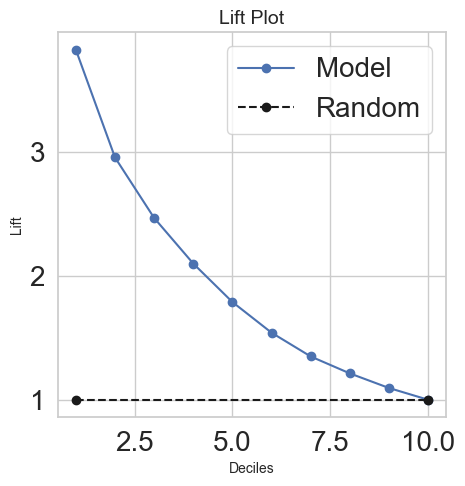

In [65]:
plt.figure(figsize=(5, 5))
kds.metrics.plot_lift(y_test, y_test_predict_proba_knn)
plt.show()

### Calcul et visualisation de l'importance des variables

In [66]:
# Calculer l'importance des variables par permutation
result = permutation_importance(knn_clf, X_test_norm, y_test, n_repeats=10, random_state=42, scoring='roc_auc')

# Organiser les résultats dans un DataFrame
importances = pd.DataFrame({'Variable': X_train_norm.columns, 'Importance': result.importances_mean})
importances = importances.sort_values(by='Importance', ascending=False)

importances

Variable  Importance
9      DEBTINC    0.142387
0       DELINQ    0.066042
2        DEROG    0.043402
6         NINQ    0.036921
5       REASON    0.016049
7  JOB_ProfExe    0.014236
3   JOB_Office    0.014226
1    JOB_Sales    0.003795
4     JOB_Self    0.003696
8      JOB_Mgr   -0.003743

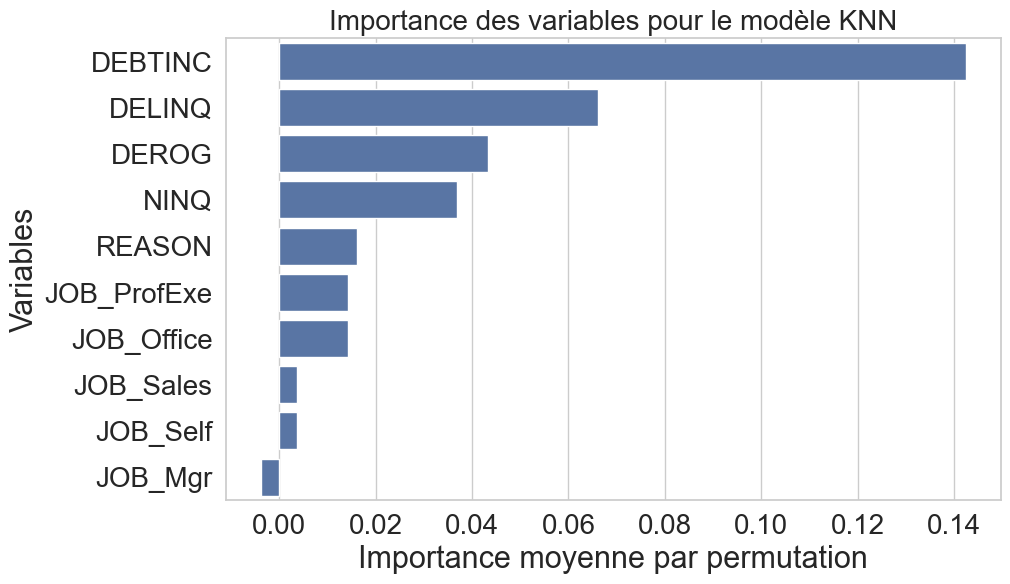

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=importances)
plt.title('Importance des variables pour le modèle KNN')
plt.xlabel('Importance moyenne par permutation')
plt.ylabel('Variables')
plt.show()

En résumé, les variables financières et l'historique de crédit sont les plus importantes pour le modèle KNN, tandis que les informations sur l'emploi sont moins influentes.

### Ajustement du modèle KNN sur données réduites

In [68]:
# Réduire les données à deux dimensions pour la visualisation
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

# Ajouter les dimensions réduites à un DataFrame pour faciliter la manipulation
df_train_pca = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
df_train_pca['target'] = y_train.values

df_test_pca = pd.DataFrame(X_test_pca, columns=['PCA1', 'PCA2'])
df_test_pca['target'] = y_test.values

# Ajuster le modèle KNN sur les données réduites
knn_clf_pca = KNeighborsClassifier(**best_param_opti_grid)
knn_clf_pca.fit(X_train_pca, y_train)

# Prédictions pour l'ensemble de test réduit
y_test_predict_pca = knn_clf_pca.predict(X_test_pca)

### Visualisation des décisions prises par le KNN

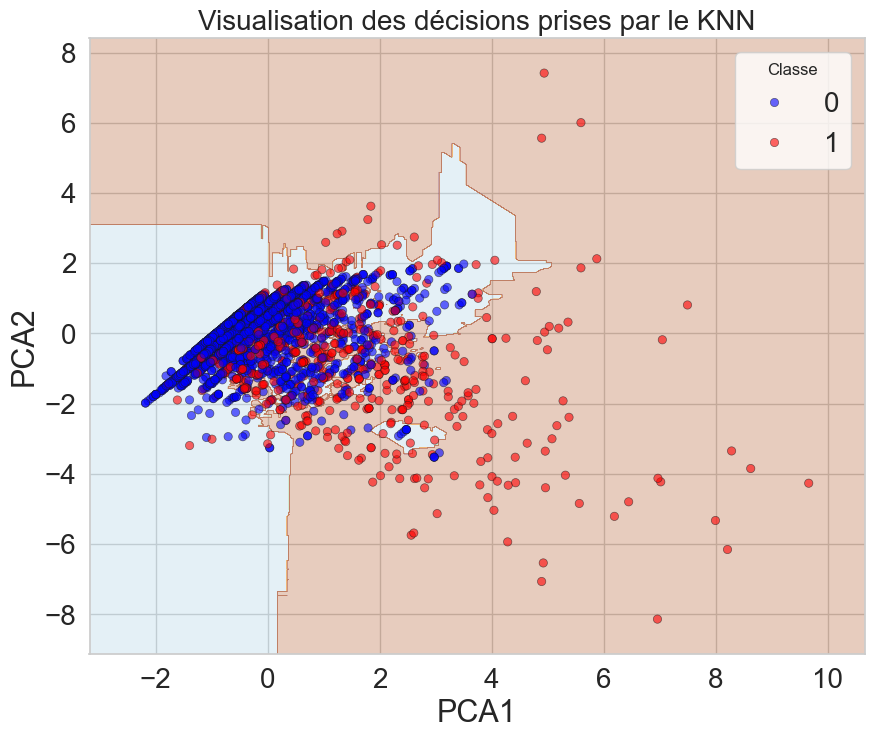

In [69]:
# Visualisation des décisions prises par le KNN
plt.figure(figsize=(10, 8))

# Créer un meshgrid pour l'arrière-plan de la visualisation
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Prédire sur l'arrière-plan du meshgrid
Z = knn_clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Afficher les frontières de décision
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

# Afficher les points de données d'entraînement
sns.scatterplot(x='PCA1', y='PCA2', hue='target', data=df_train_pca,
                palette={0: 'blue', 1: 'red'}, alpha=0.6, edgecolor='k')

# Titre et légendes
plt.title('Visualisation des décisions prises par le KNN')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Classe')
plt.show()


La visualisation 2D des décisions prises par le modèle KNN montre les frontières de décision entre les classes après réduction dimensionnelle par PCA. Les points représentent les observations, avec les bleus pour la classe 0 et les rouges pour la classe 1. Les zones en arrière-plan coloré indiquent les décisions du modèle : bleu clair pour non-défaillant et rouge clair pour défaillant. Les frontières de décision sont complexes en raison de la nature des KNN, basé sur la proximité des voisins. La présence de points rouges dans les zones bleues et vice versa signale des erreurs de classification, suggérant des zones de faible confiance. Cette visualisation aide à identifier les zones où le modèle performe bien et où il pourrait être amélioré, offrant une validation visuelle précieuse en complément des métriques quantitatives.

## <span style="color:#389696;">Modèle bonus : XGBoost</span>

### Renommage des colonnes

In [70]:
char_to_remove = ["[", "]", ";", "<", ">"]
new_var_names = []

for col in X_train_norm.columns:
    for char in char_to_remove:
        col = col.replace(char, "")
    new_var_names.append(col)

X_train_renamed = X_train_norm.copy()  # enlever 'const' et éviter d'écraser le dataframe X_train

X_test_renamed = X_test_norm.copy()  # enlever 'const' et éviter d'écraser le dataframe X_test

### Espace de recherche des hyperparamètres

In [71]:
param_dict_XGB = {
    'objective': ['binary:logistic'],
    'booster': ['gbtree'],  # 'gblinear', 'dart' peuvent être ajoutés
    'learning_rate': [0.05, 0.1, 0.3, 0.5, 0.7, 1],  # Intervalle de valeurs pour le taux d'apprentissage
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],  # Profondeur maximale des arbres
    'n_estimators': [50, 100, 150, 200]  # Nombre d'arbres
}

### Recherche des hyperparamètres optimaux

In [72]:
# Instanciation de GridSearchCV
grid_search = GridSearchCV(xgb.XGBClassifier(), param_dict_XGB, cv=5, scoring='roc_auc', n_jobs=-1)

# Recherche des hyperparamètres optimaux 
start = timer()
grid_search.fit(X_train_renamed, y_train)
delais = timer() - start

# Affichage des résultats
print("#### RECHERCHE DES PARAMETRES OPTIMAUX POUR XGBOOST ####")
print("\nDurée de recherche en secondes :", delais)
print("\nParamètres optimaux :")
best_param_opti_grid = grid_search.best_params_
print(best_param_opti_grid)
best_score_opti_grid = grid_search.best_score_
print("\nMeilleur score : " + str(best_score_opti_grid))

#### RECHERCHE DES PARAMETRES OPTIMAUX POUR XGBOOST ####

Durée de recherche en secondes : 39.9482147000017

Paramètres optimaux :
{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'objective': 'binary:logistic'}

Meilleur score : 0.8886362887390884


### Construction du modèle XGBoost

In [73]:
xgb_clf = xgb.XGBClassifier(**grid_search.best_params_)
xgb_clf.fit(X_train_renamed, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Importance des variables

In [74]:
# DataFrame contenant l'importance des variables
importance_variable_xgb = pd.DataFrame()
importance_variable_xgb["Variable"] = X_train.columns
importance_variable_xgb["Feature Importance"] = xgb_clf.feature_importances_

importance_variable_xgb.sort_values(by="Feature Importance", axis=0, ascending=False, inplace=True)
importance_variable_xgb

Variable  Feature Importance
0       DELINQ            0.320037
9      DEBTINC            0.222849
2        DEROG            0.134417
1    JOB_Sales            0.056193
6         NINQ            0.053405
3   JOB_Office            0.048338
5       REASON            0.047986
8      JOB_Mgr            0.045350
7  JOB_ProfExe            0.037283
4     JOB_Self            0.034141

### Visualisation des courbes habituelles

In [75]:
# Visualisation des courbes ROC et Precision-Recall
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

y_train_predict_proba = xgb_clf.predict_proba(X_train_renamed)[:, 1]
y_test_predict_proba = xgb_clf.predict_proba(X_test_renamed)[:, 1]

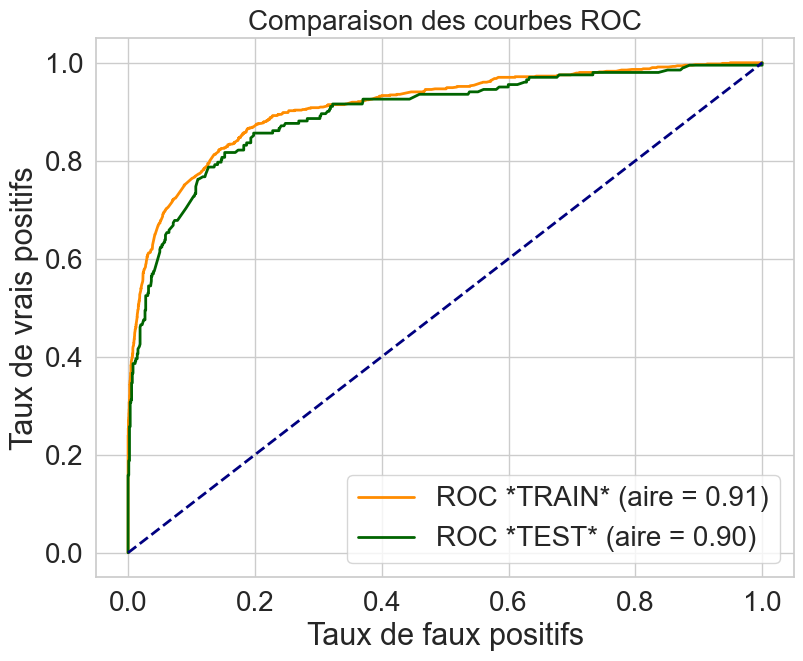

In [76]:
# Calcul des courbes ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_predict_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba)
roc_auc_train = roc_auc_score(y_train, y_train_predict_proba)
roc_auc_test = roc_auc_score(y_test, y_test_predict_proba)

# Courbe ROC
plt.figure(figsize=(9, 7))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC *TRAIN* (aire = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkgreen', lw=2, label=f'ROC *TEST* (aire = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Comparaison des courbes ROC')
plt.legend(loc="lower right")
plt.show()

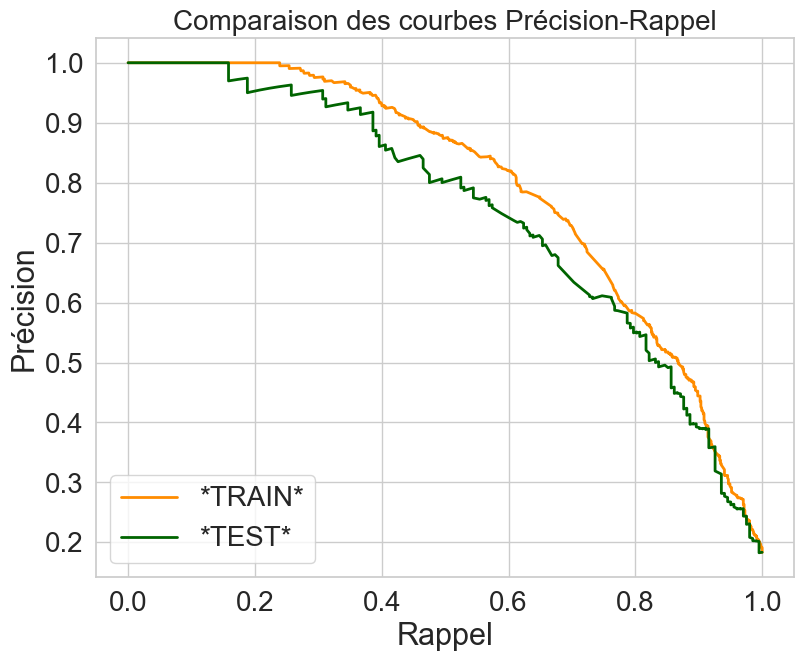

In [77]:
# Calcul des courbes Precision-Recall
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_predict_proba)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_predict_proba)

# Courbe Precision-Recall
plt.figure(figsize=(9, 7))
plt.plot(recall_train, precision_train, color='darkorange', lw=2, label='*TRAIN*')
plt.plot(recall_test, precision_test, color='darkgreen', lw=2, label='*TEST*')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Comparaison des courbes Précision-Rappel')
plt.legend(loc="lower left")
plt.show()

### Compréhension des prédictions avec les valeurs de Shapley

Pourquoi utiliser les valeurs de Shapley ?

- **Interprétation des résultats** : Les algorithmes de boosting comme XGBoost peuvent être des "boîtes noires" difficiles à interpréter.

- **Impact des variables** : Les valeurs de Shapley nous aident à déterminer quelles variables ont un impact significatif sur les prédictions.

- **Direction de l'impact** : Elles nous indiquent si l'impact d'une variable est positif ou négatif.

In [78]:
# Création d'un explicateur SHAP pour XGBoost
explainer = shap.Explainer(xgb_clf, X_train_renamed)

In [79]:
# Calcul des valeurs SHAP pour le jeu de données de test
shap_values_test = explainer(X_test_renamed)

# Calcul des valeurs SHAP pour le jeu de données d'entraînement
shap_values_train = explainer(X_train_renamed)

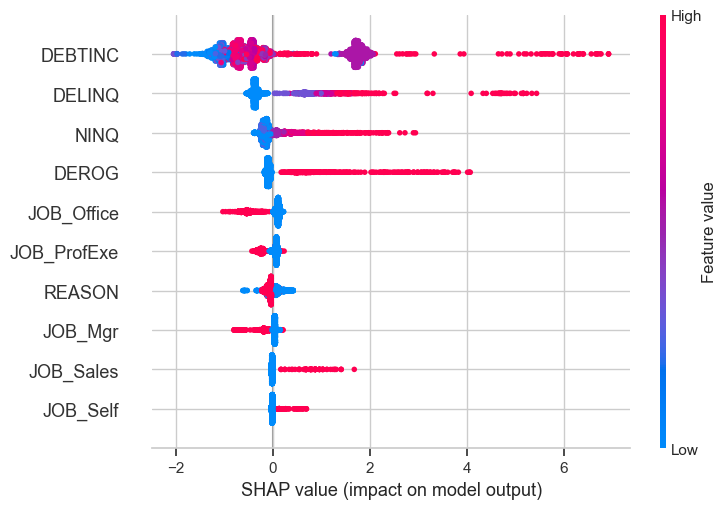

In [80]:
# Visualisation globale des contributions des variables
shap.summary_plot(shap_values_train, X_train_renamed)

Lecture de la sortie : plus la variable DELINQ est positive, plus le risque de défaut de paiement sera élevé.

Au-delà d'éléments de réponses pour le modèle en général, le package pourrait nous donner des informations pour une prédiction en particulier.

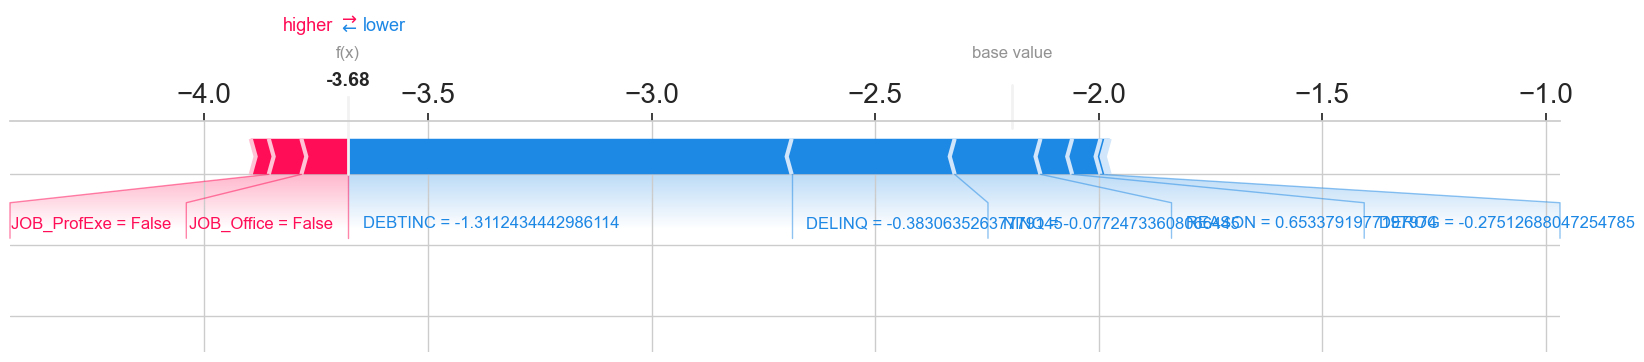

In [81]:
# Visualisation des contributions des variables pour une prédiction spécifique
shap.force_plot(shap_values_test[5], X_test_renamed.iloc[5], matplotlib=True)

Lecture de la sortie : pour la prédiction de l'observation 5 sur X_test, les variables qui poussent vers une diminution du score sont principalement DEBTINC et DELINQ.

## <span style="color:#389696;">Utilisation de Sagemaker sur le modèle Decision Tree</span>

In [99]:
import sagemaker
from sagemaker.sklearn import SKLearn
import boto3

# Créer une session boto3
boto3_session = boto3.Session(region_name='eu-west-3')

# Créer une session SageMaker
sess = sagemaker.Session(boto_session=boto3_session)

# Définir le nom du bucket S3
bucket = 'bucketbigdatasagemaker'

# Vérifier que le compartiment est correctement défini
print('Compartiment utilisé : ' + bucket)

# Charger les fichiers CSV dans le bucket S3
s3_client = boto3.client('s3')
s3_client.upload_file('train_data.csv', bucket, 'train/train_data.csv')
s3_client.upload_file('test_data.csv', bucket, 'test/test_data.csv')

print("Les données d'entraînement et de test ont été téléchargées dans le bucket S3.")

# Configurer l'estimateur SageMaker
sklearn_estimator = SKLearn(
    entry_point='train.py',
    role='arn:aws:iam::381492285049:role/service-role/AmazonSageMaker-ExecutionRole-20240425T160745',
    instance_count=1,
    instance_type='ml.m5.large',
    framework_version='0.23-1',
    py_version='py3',
    output_path=f's3://{bucket}/output',
    hyperparameters={
        'criterion': 'gini',
        'max_depth': 5,
        'min_samples_split': 10,
        'min_samples_leaf': 2,
        'max_features': 'sqrt'
    }
)

# Définir les chemins des données S3
train_data_s3_path = f's3://{bucket}/train'
test_data_s3_path = f's3://{bucket}/test'

# Lancer l'entraînement
sklearn_estimator.fit({'train': train_data_s3_path, 'test': test_data_s3_path})

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Compartiment utilisé : bucketbigdatasagemaker
Les données d'entraînement et de test ont été téléchargées dans le bucket S3.


INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-05-25-16-18-58-984


2024-05-25 16:18:58 Starting - Starting the training job...
2024-05-25 16:19:16 Starting - Preparing the instances for training...
2024-05-25 16:19:40 Downloading - Downloading input data...
2024-05-25 16:20:05 Downloading - Downloading the training image...
2024-05-25 16:20:56 Training - Training image download completed. Training in progress.
2024-05-25 16:20:56 Uploading - Uploading generated training model2024-05-25 16:20:50,056 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-05-25 16:20:50,060 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-05-25 16:20:50,104 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-05-25 16:20:50,258 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-05-25 16:20:50,270 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-05-25 16:20:50,283 sagemaker-training-toolkit INFO

Dans cette section, nous avons configuré notre modèle Decision Tree pour l'entraînement sur SageMaker. En utilisant la même approche que vue en cours, nous avons préparé un script train.py qui charge les données, entraîne le modèle, et sauvegarde les résultats. Le notebook principal gère la soumission de ce script à SageMaker, où l'entraînement se fait de manière distribuée et automatisée. Cela permet de profiter des avantages de SageMaker, notamment la gestion des ressources, la scalabilité et l'intégration facile avec d'autres services AWS.